In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
import glob
import geopandas as gpd
from geopandas.tools import sjoin
#import descartes as des
import rasterstats as rs
import rioxarray
import xarray as xr
import seaborn as sns
import inmap_funcs as ihf #inmap helper funcs = ihf
import importlib #To let us re-import with changes to module
import statsmodels.api as sm
sns.set_style('ticks')

/home/tfmrodge/inmapenv/lib/python3.10/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [10]:
# for vals in [['BasePM25','TotalPM25'],['BasePNO3','PNO3'],['BasePNH4',
# #                               'PNH4'],['BasePSO4','PSO4'],['BaseSOA','SOA'],['BasePrimPM25','PrimPM25']]:
# #     inmap_outs.loc[:,vals[0]]=-1*inmap_outs.loc[:,vals[0]]
# axs[0].set_xlim(-2579201.070414297, 3165870.);
# axs[0].set_ylim(76856.48815160134, 4270028.);
# #Mapping Limits [xlims,(ylims)]
# #canada
# limits=[(-2579201.070414297,3165870.),(76856.48815160134,4270028.)]
# #BC
# limits=[(-2200000,-1300000),(1190000,1800000)]
# #Windsor-QC
# limits=[(1088000,1900000),(332000,1250000)]
# #AB
# limits=[(-1649863, -320431.),(1104737, 2236402.)]
inmap_outs.PNO3.min()

-5.3729617e-08

/lustre03/project/6016368/tfmrodge/InMAP_Canada/data_scripts/inmap_funcs.py:251: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m,r2 = res.params[0],res.rsquared
/lustre03/project/6016368/tfmrodge/InMAP_Canada/data_scripts/inmap_funcs.py:251: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m,r2 = res.params[0],res.rsquared
/lustre03/project/6016368/tfmrodge/InMAP_Canada/data_scripts/inmap_funcs.py:251: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

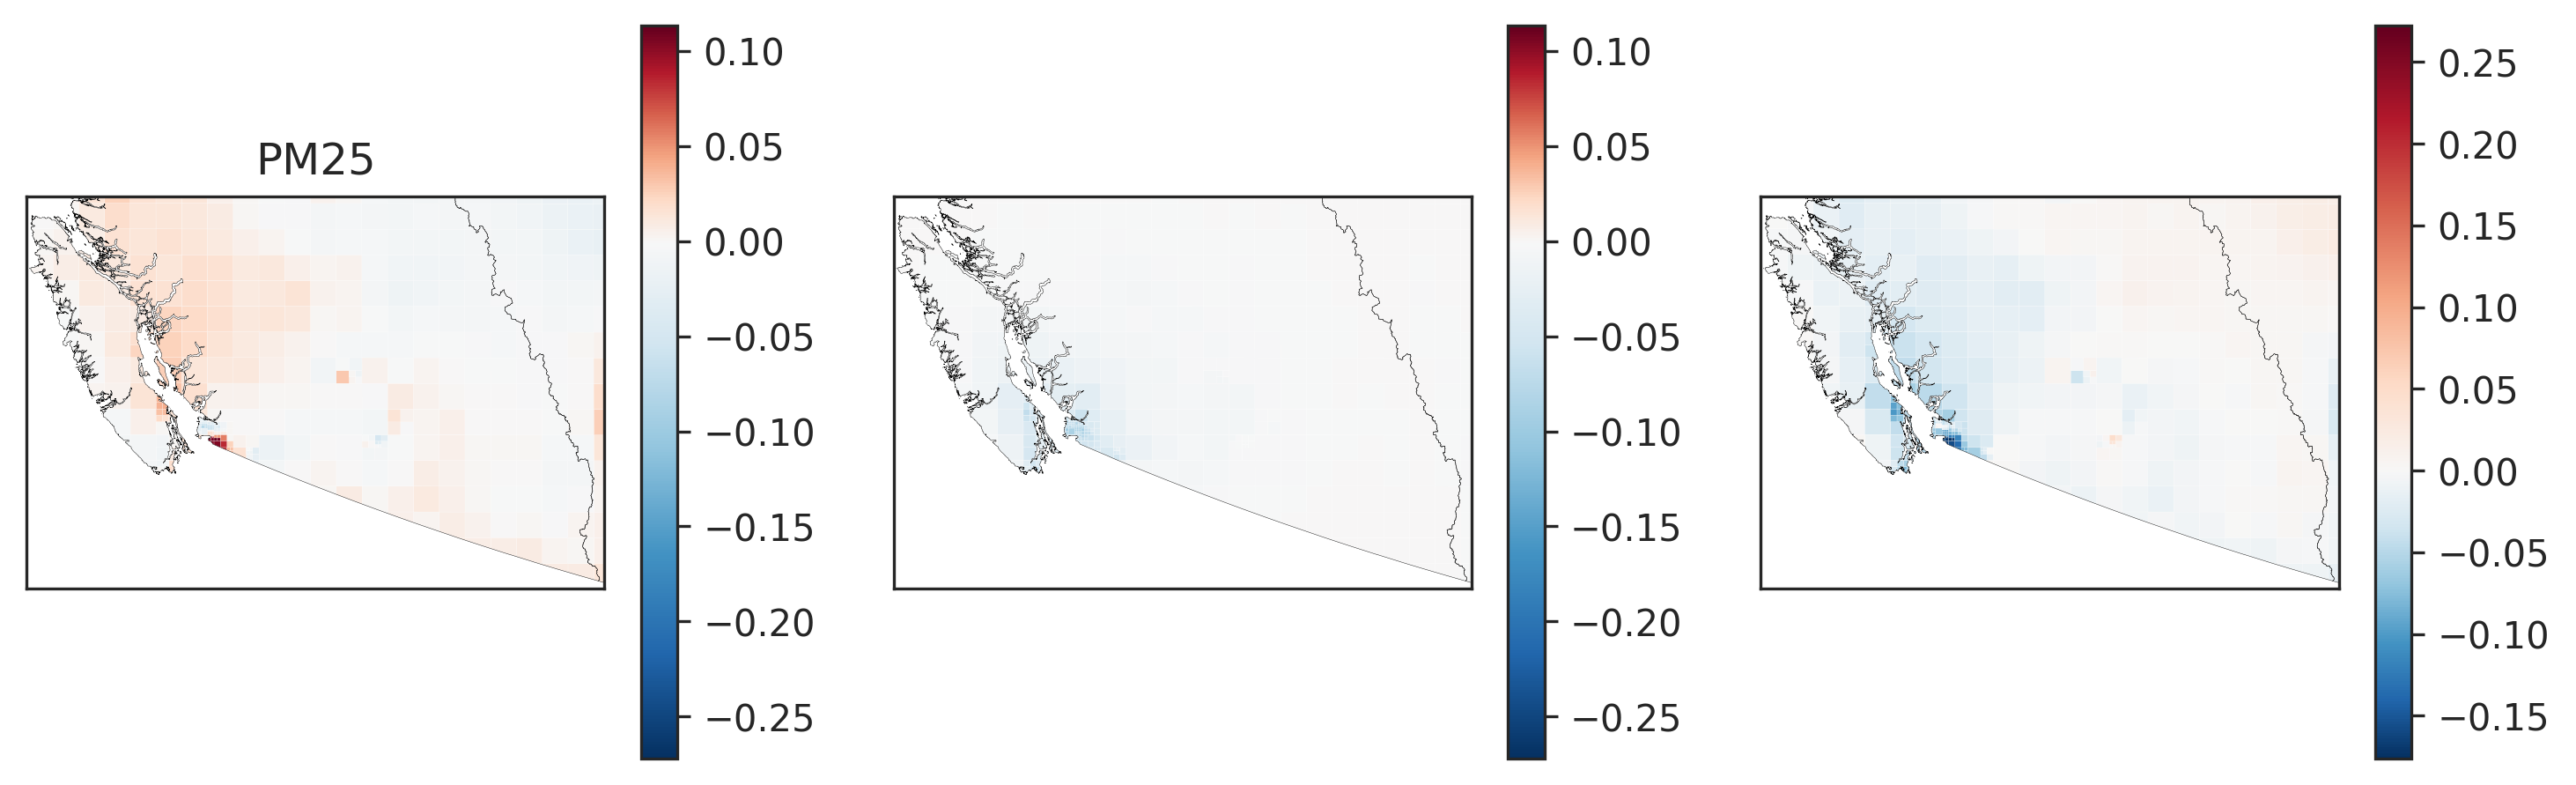

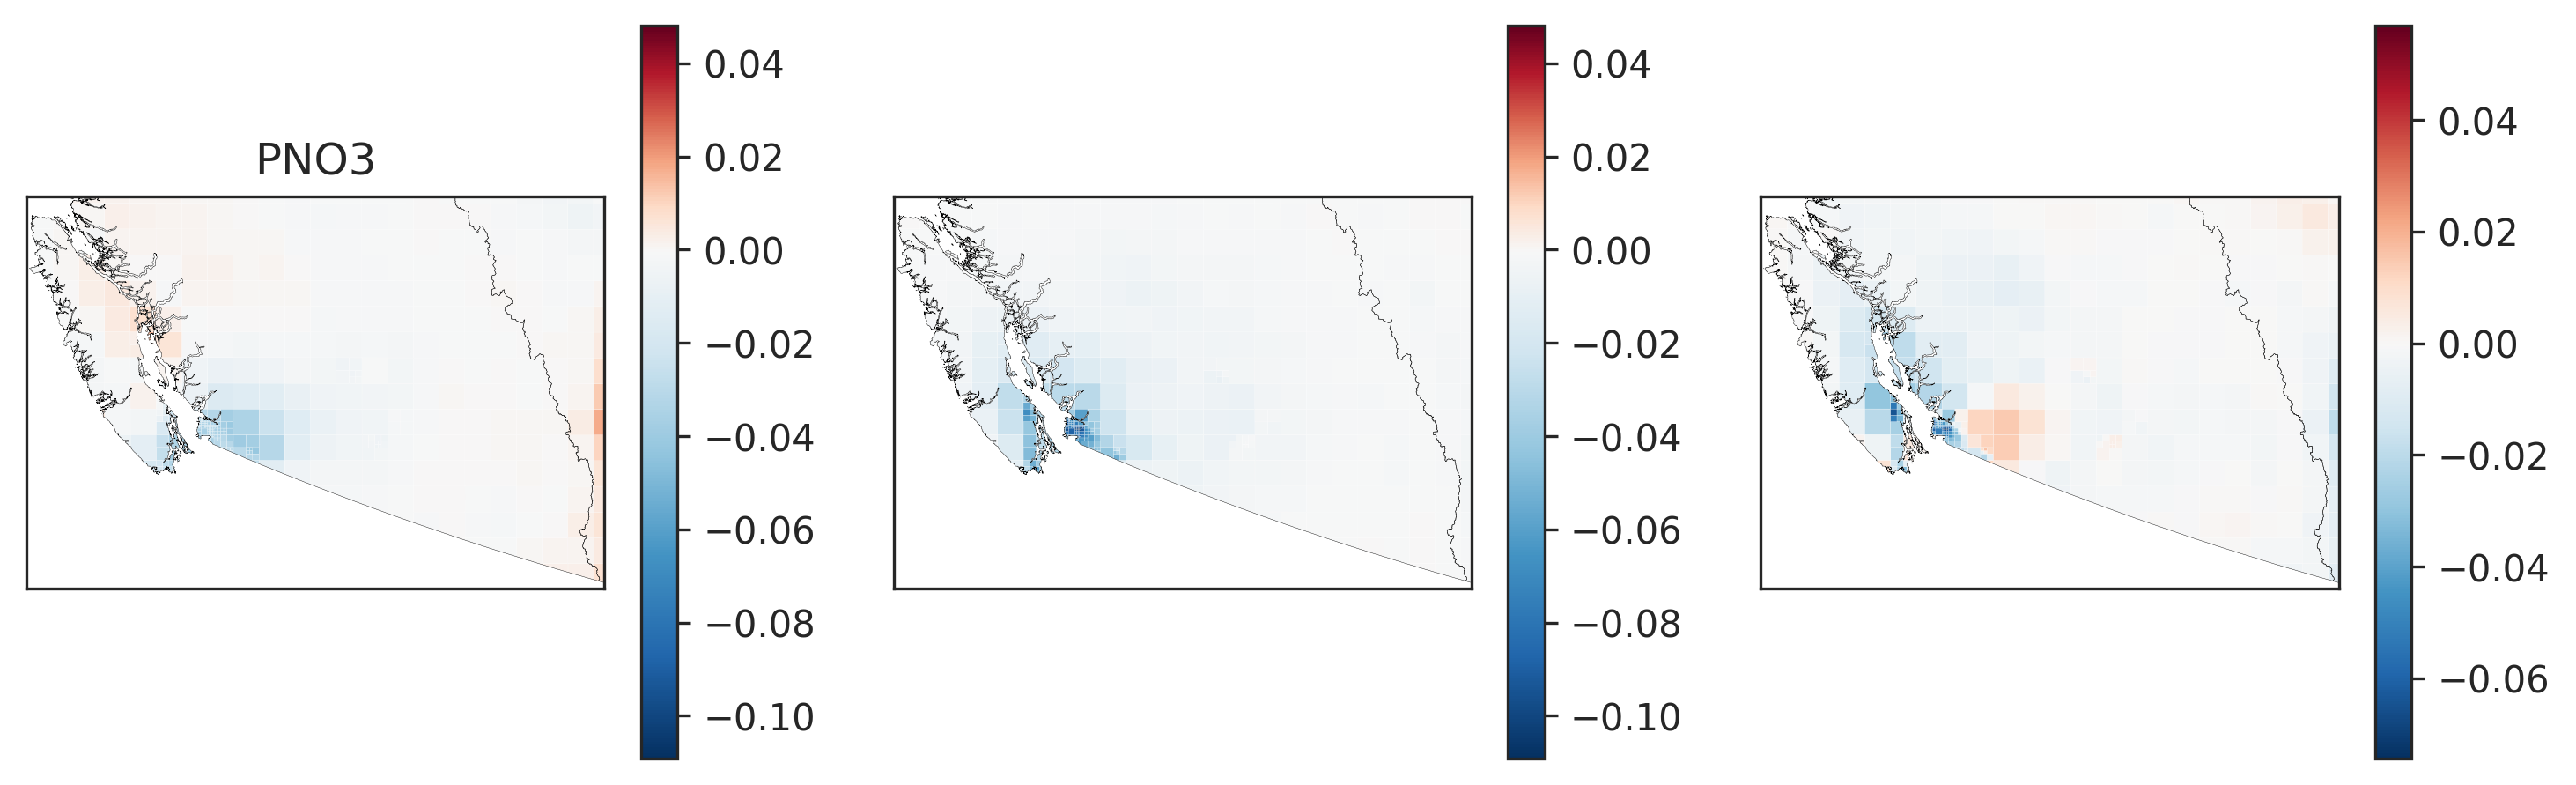

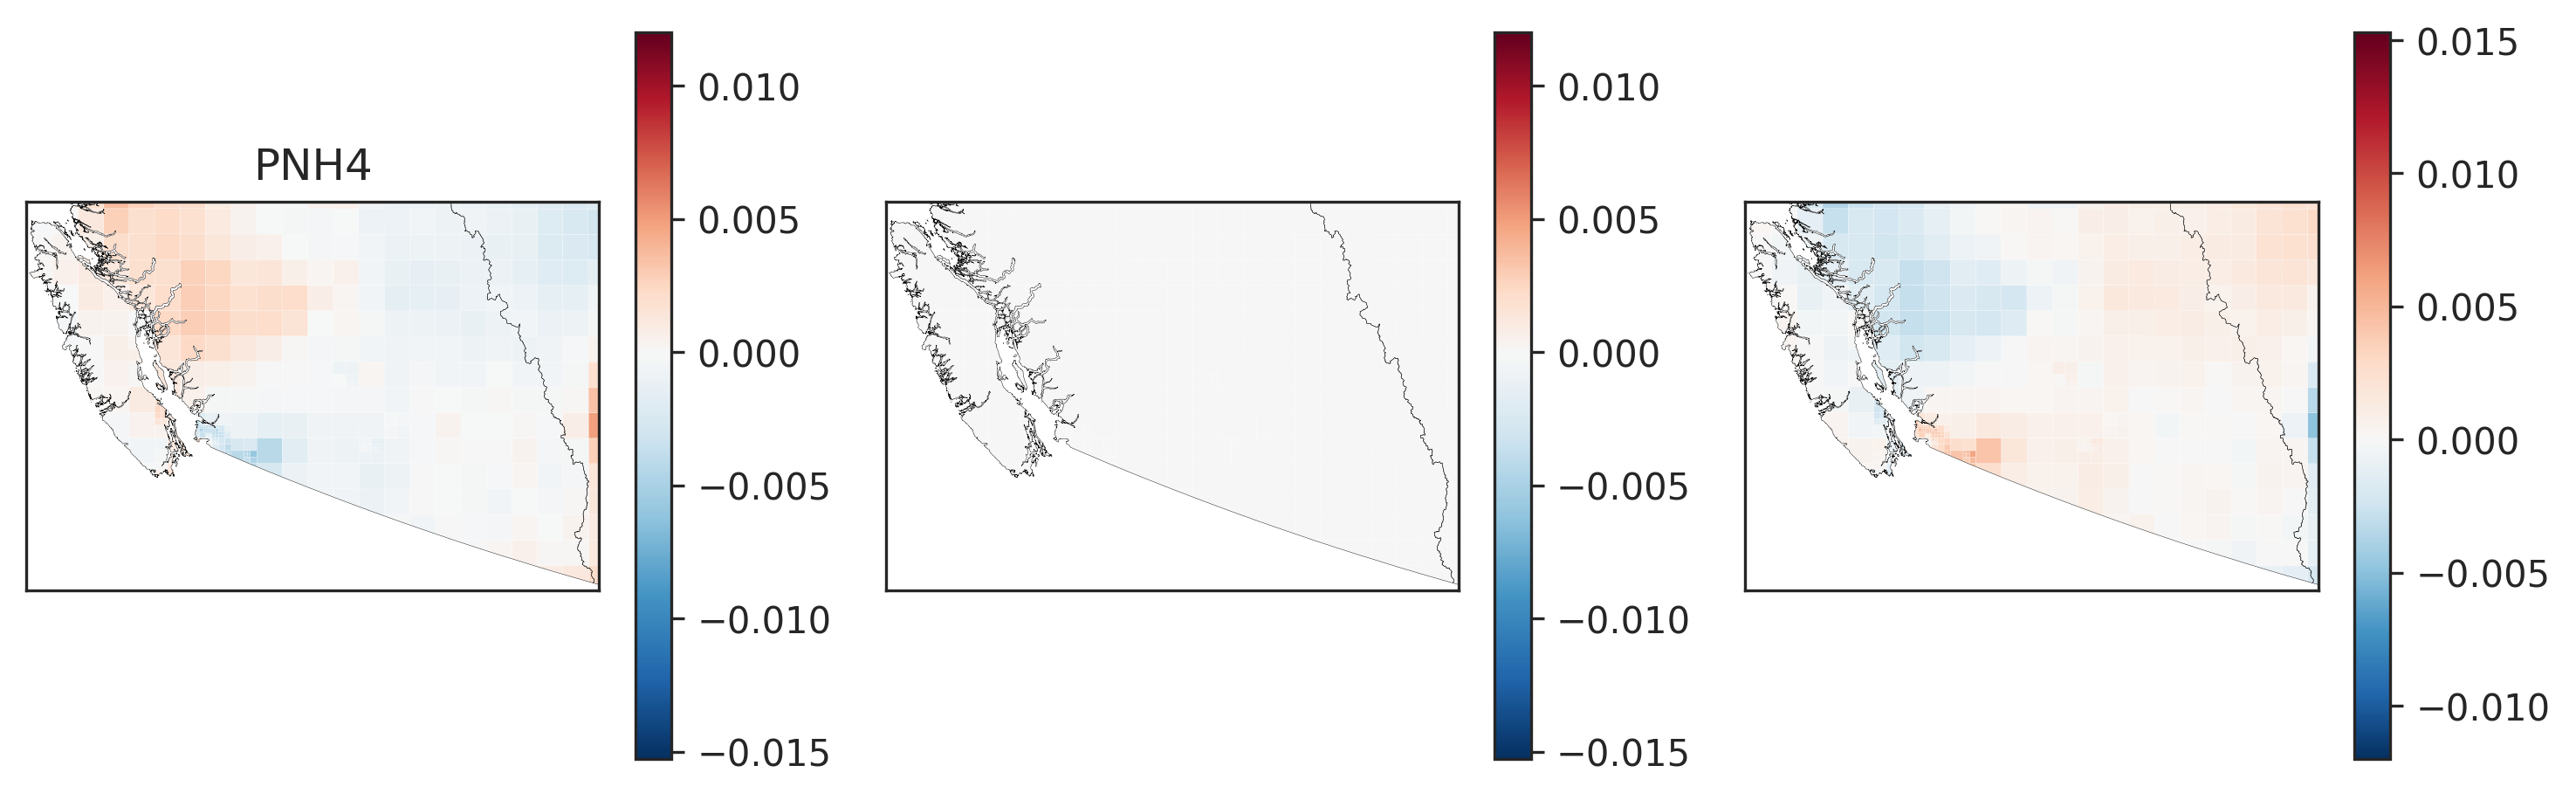

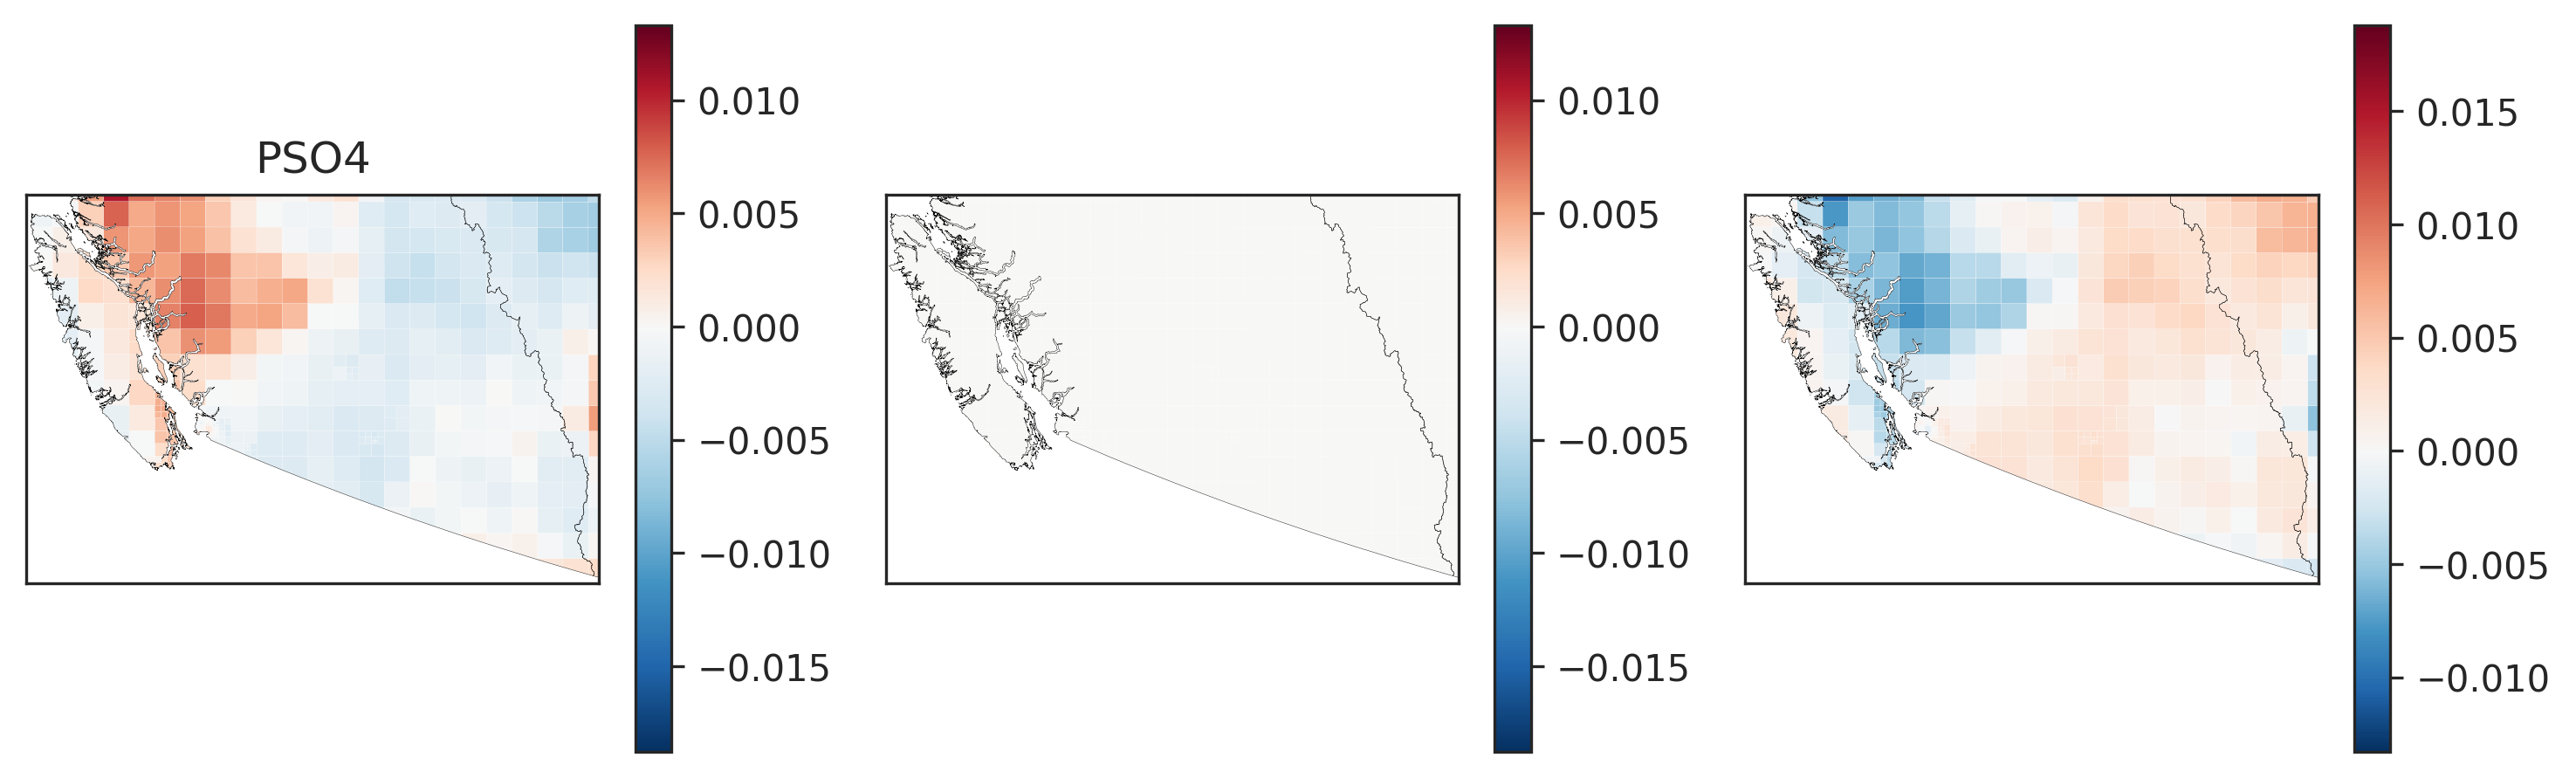

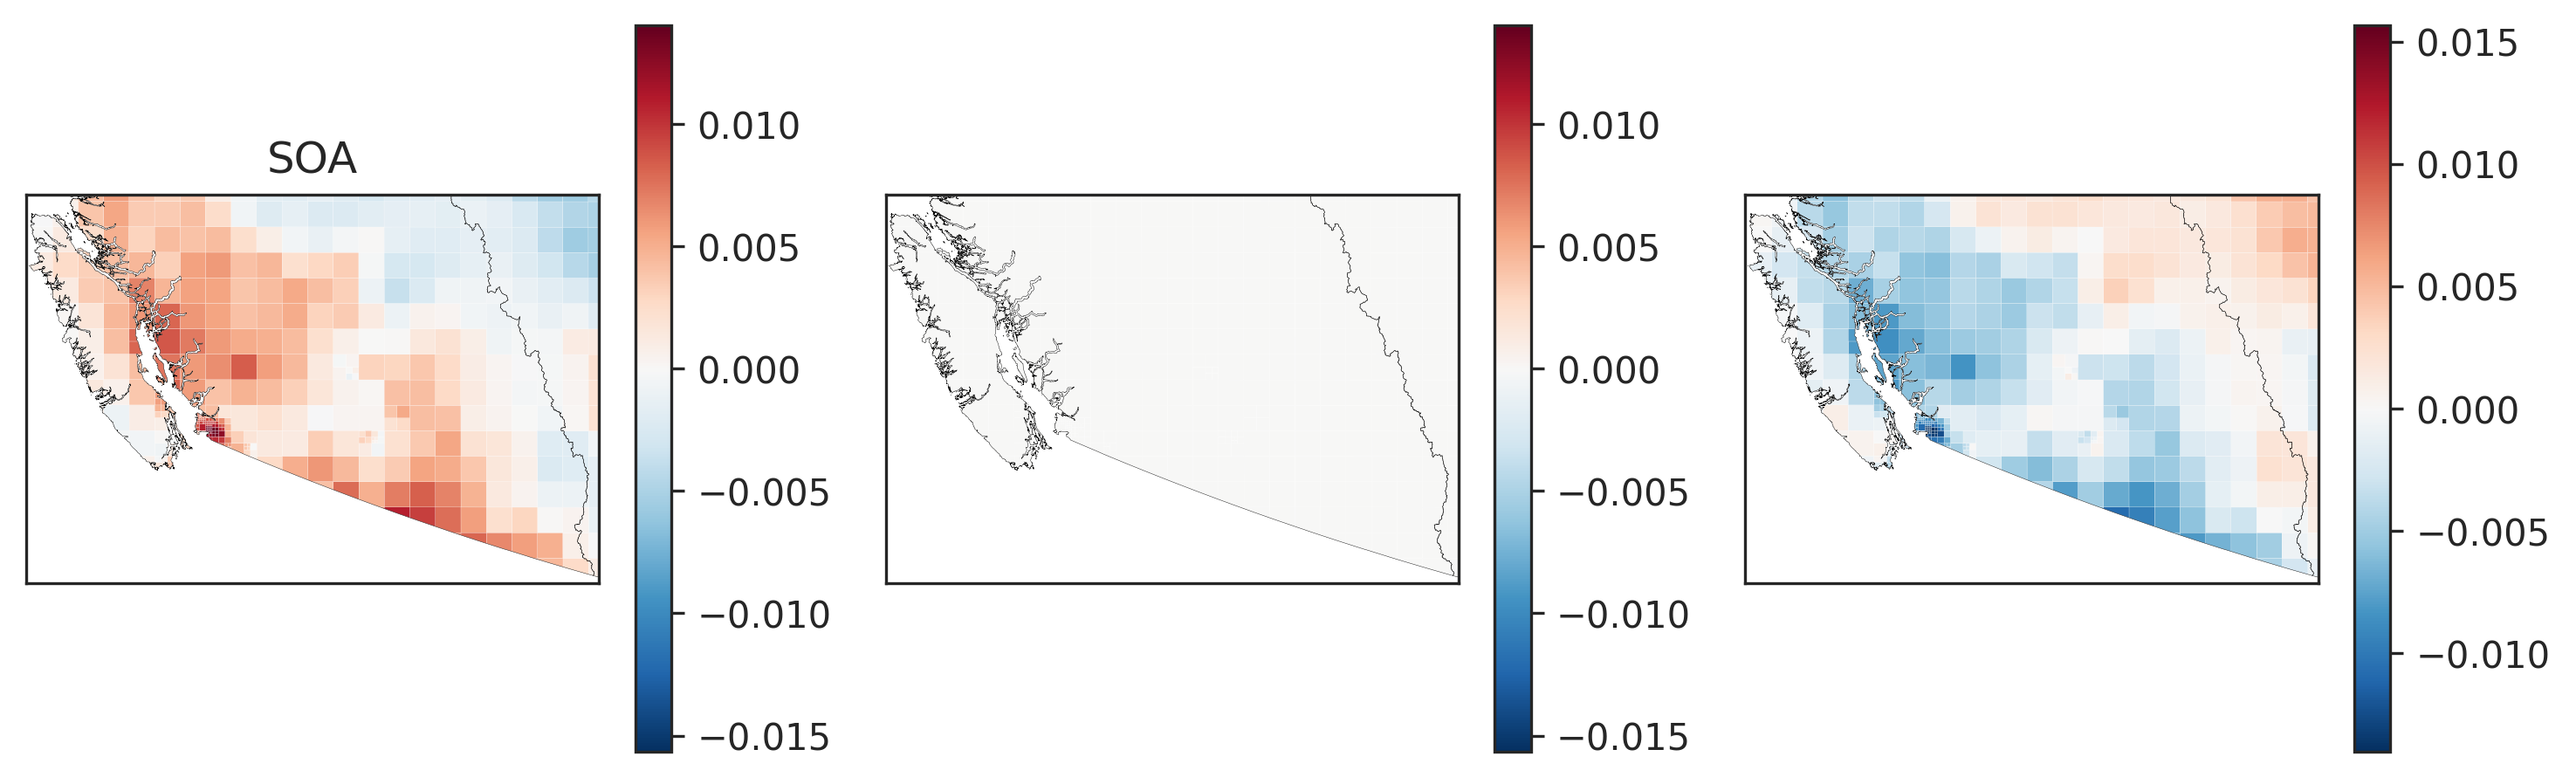

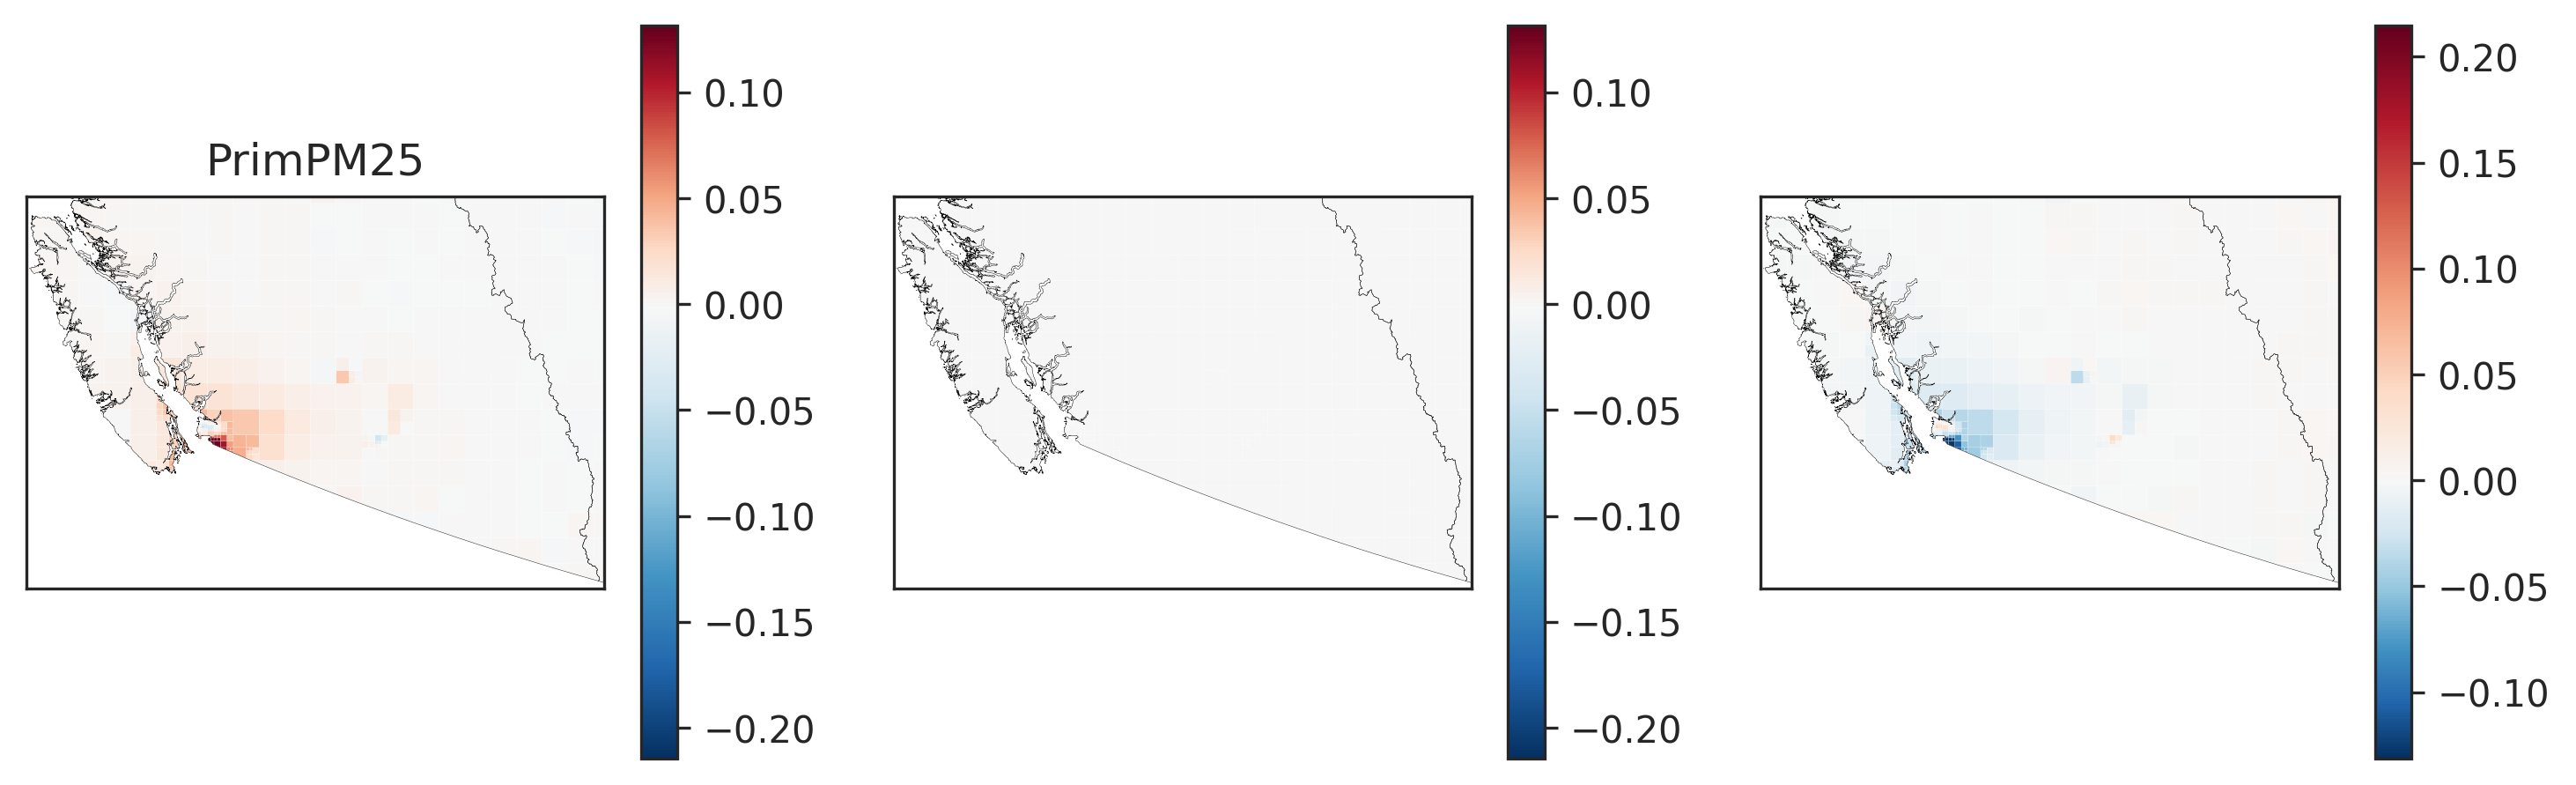

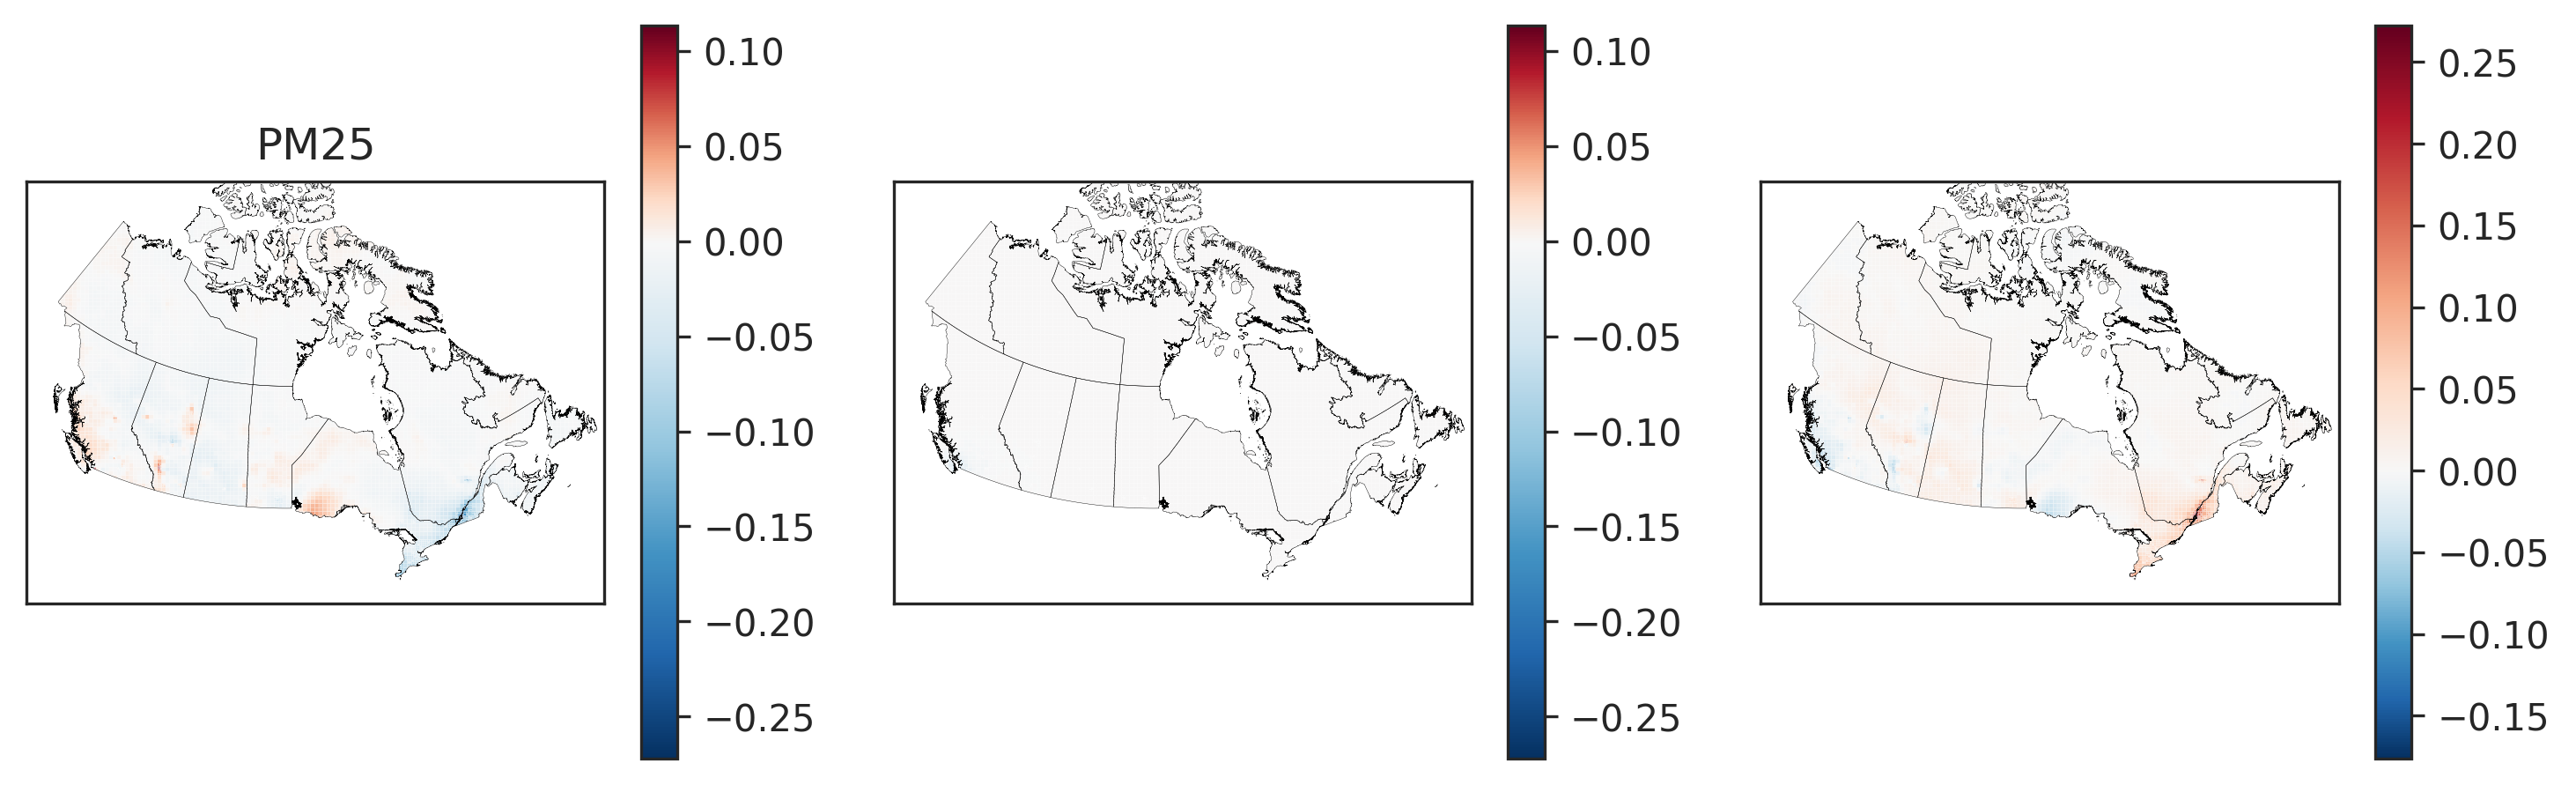

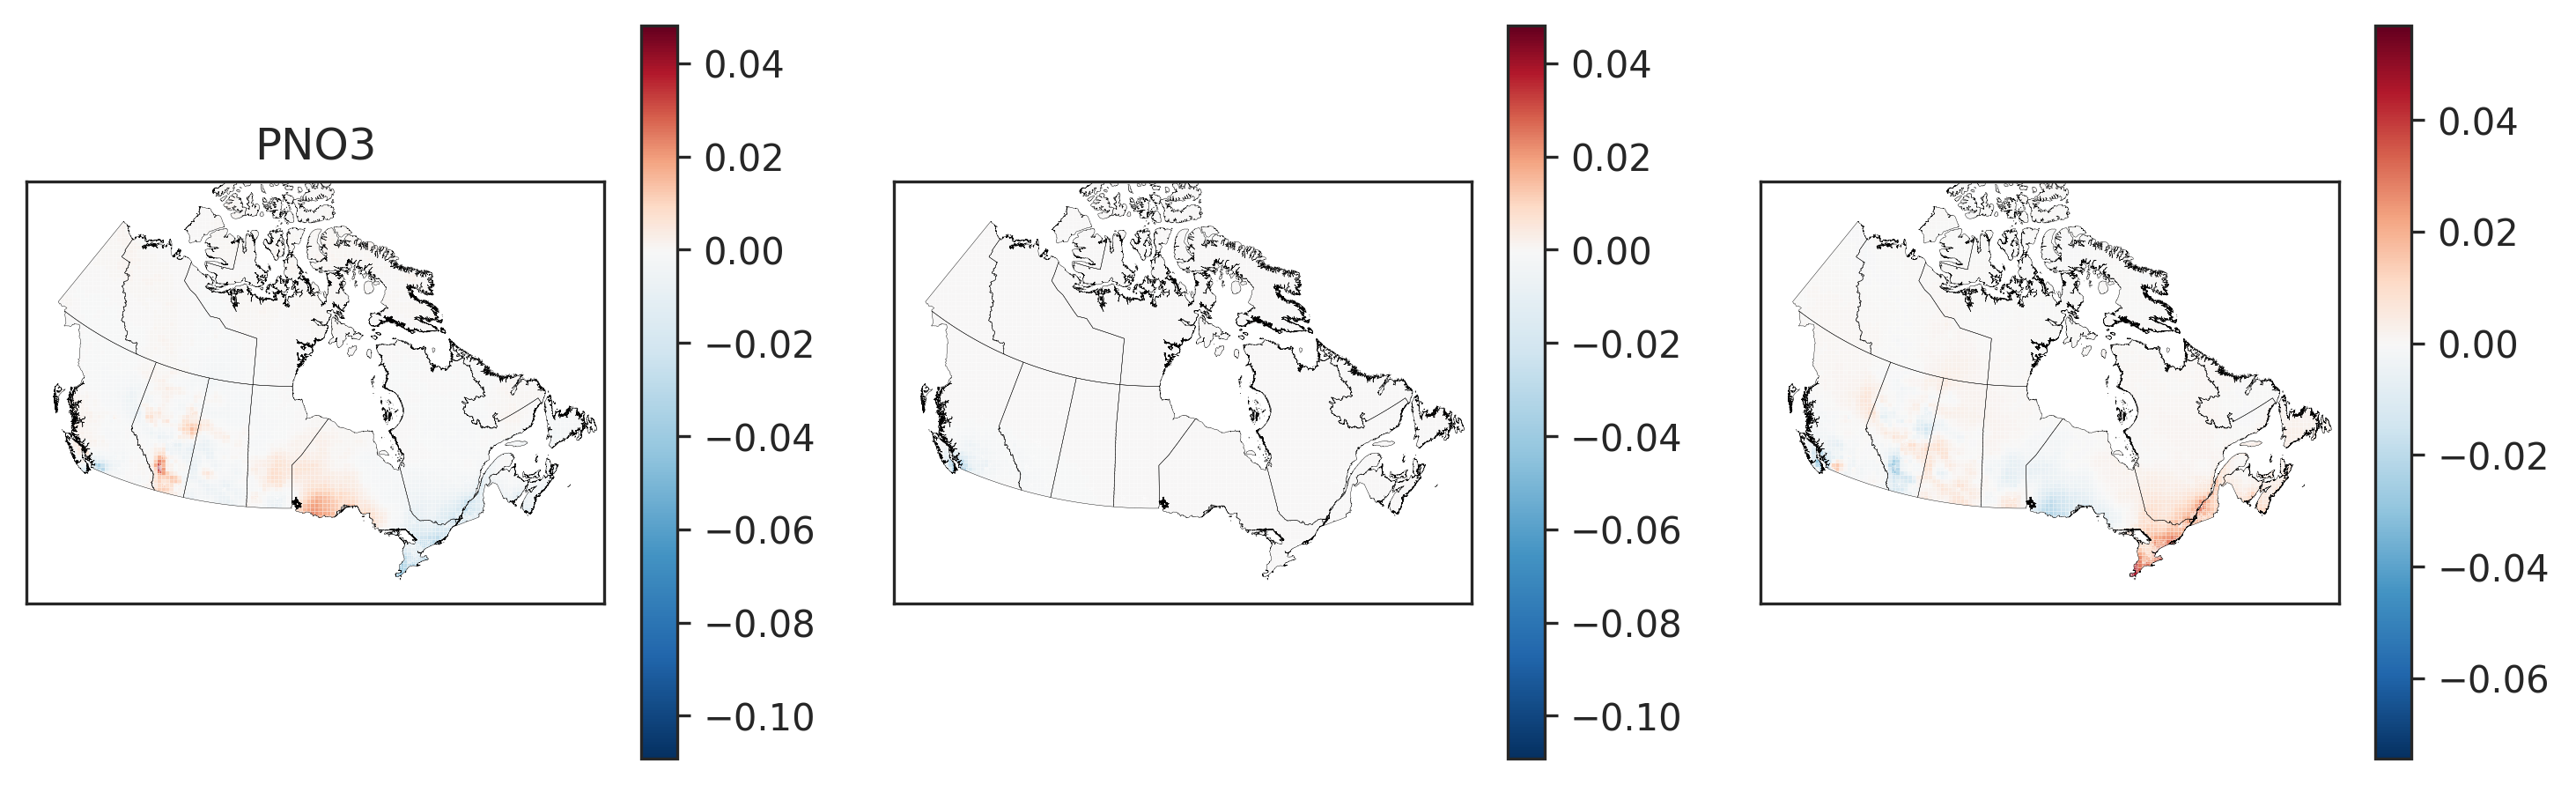

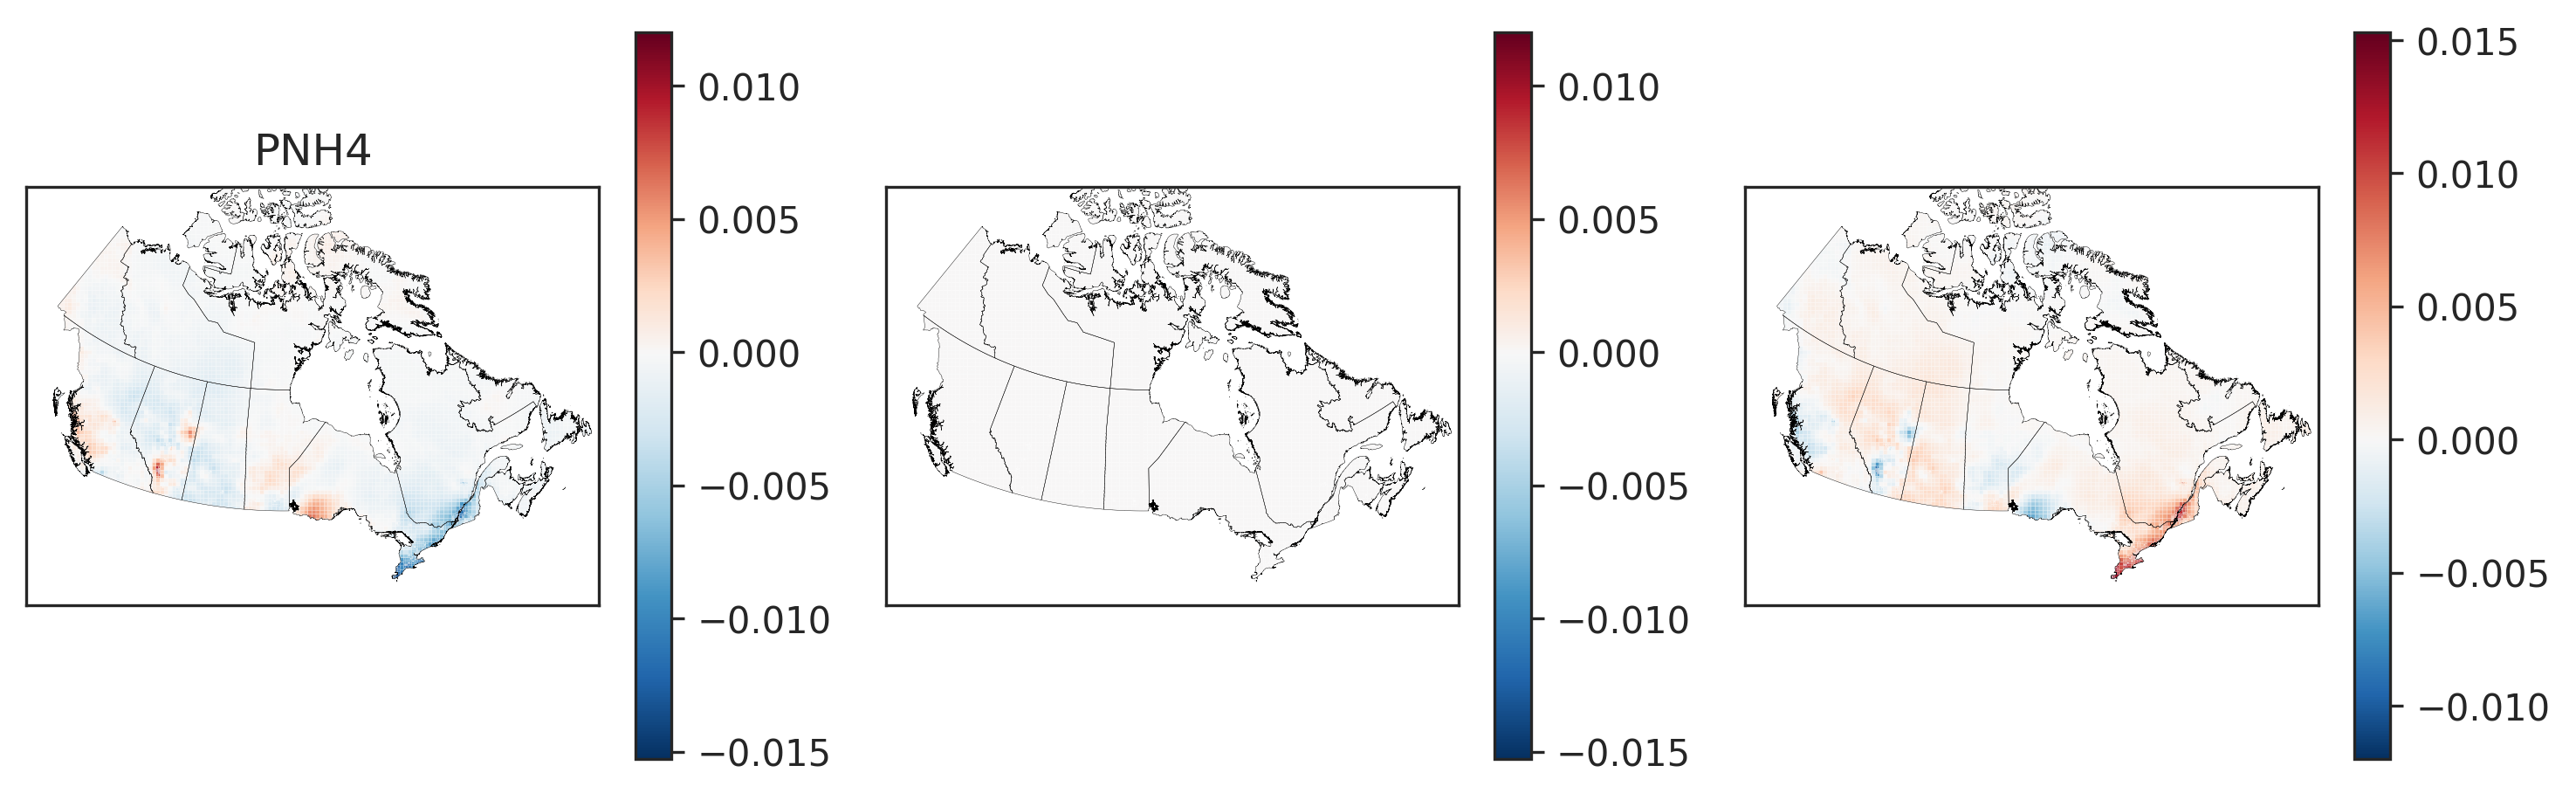

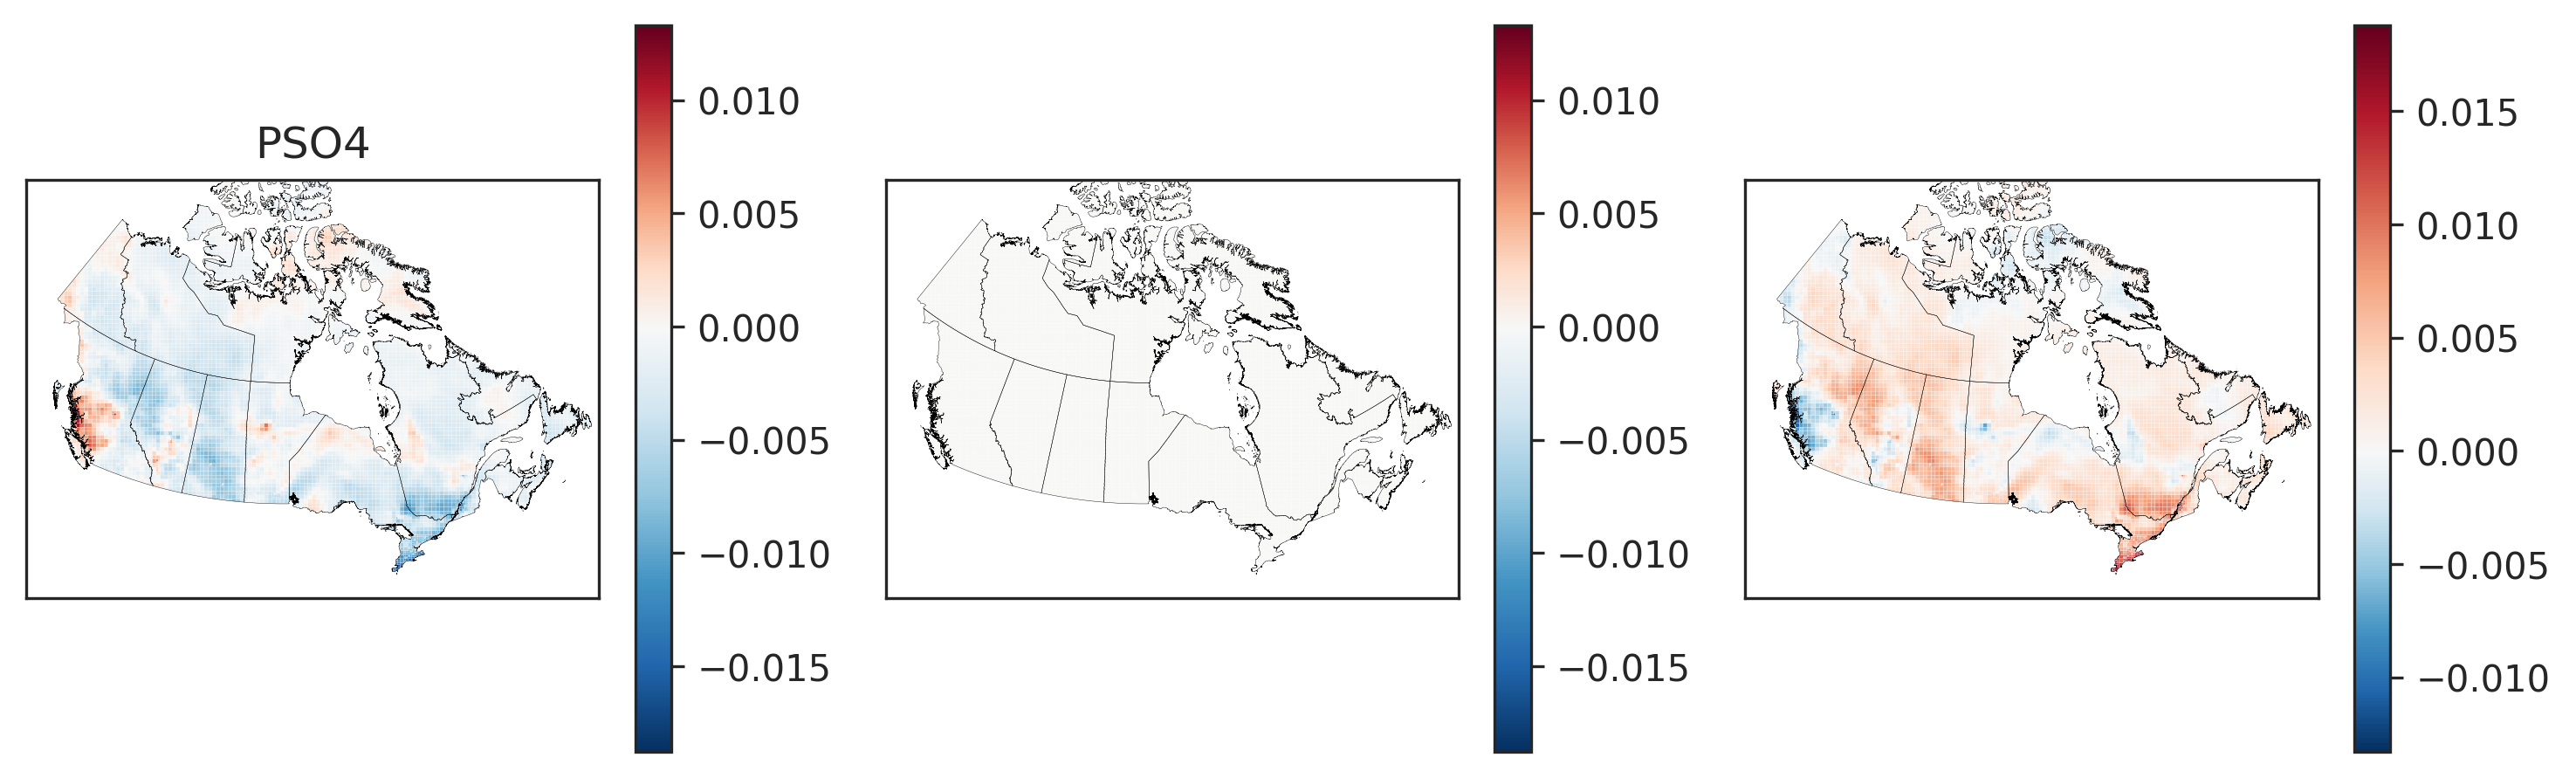

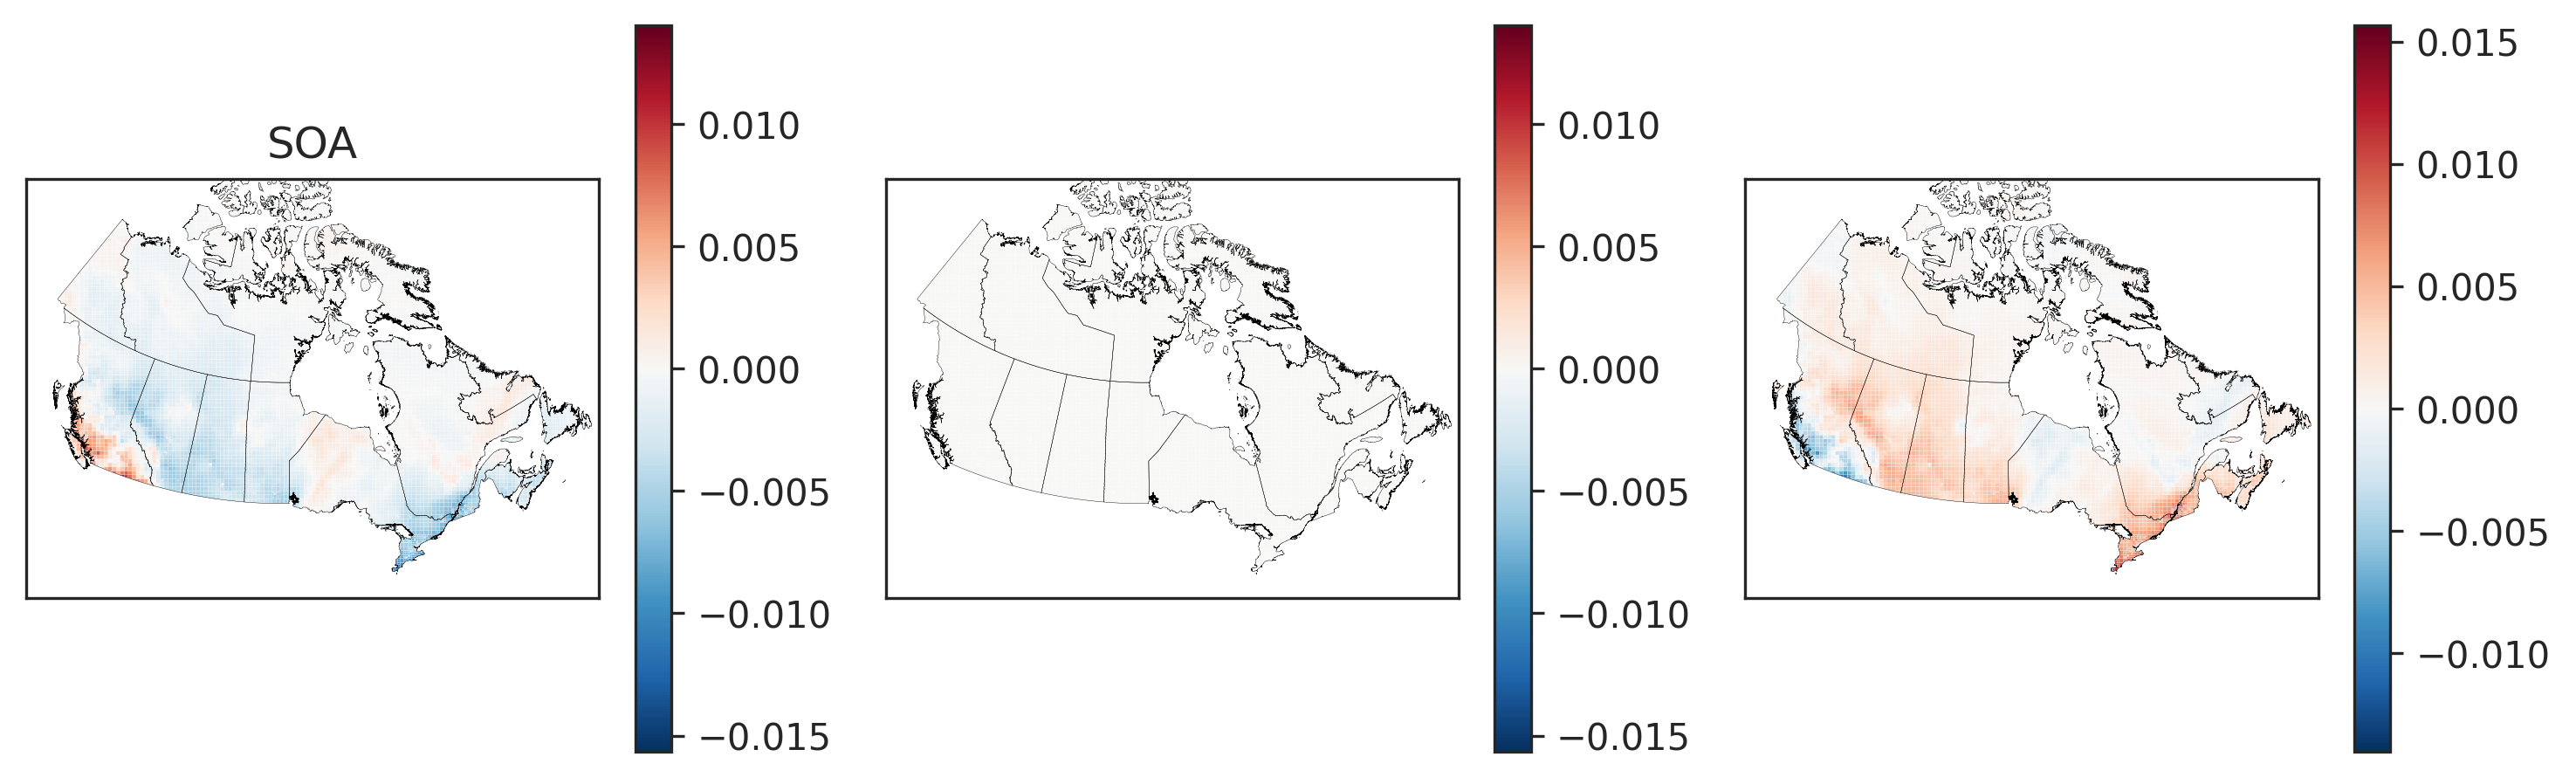

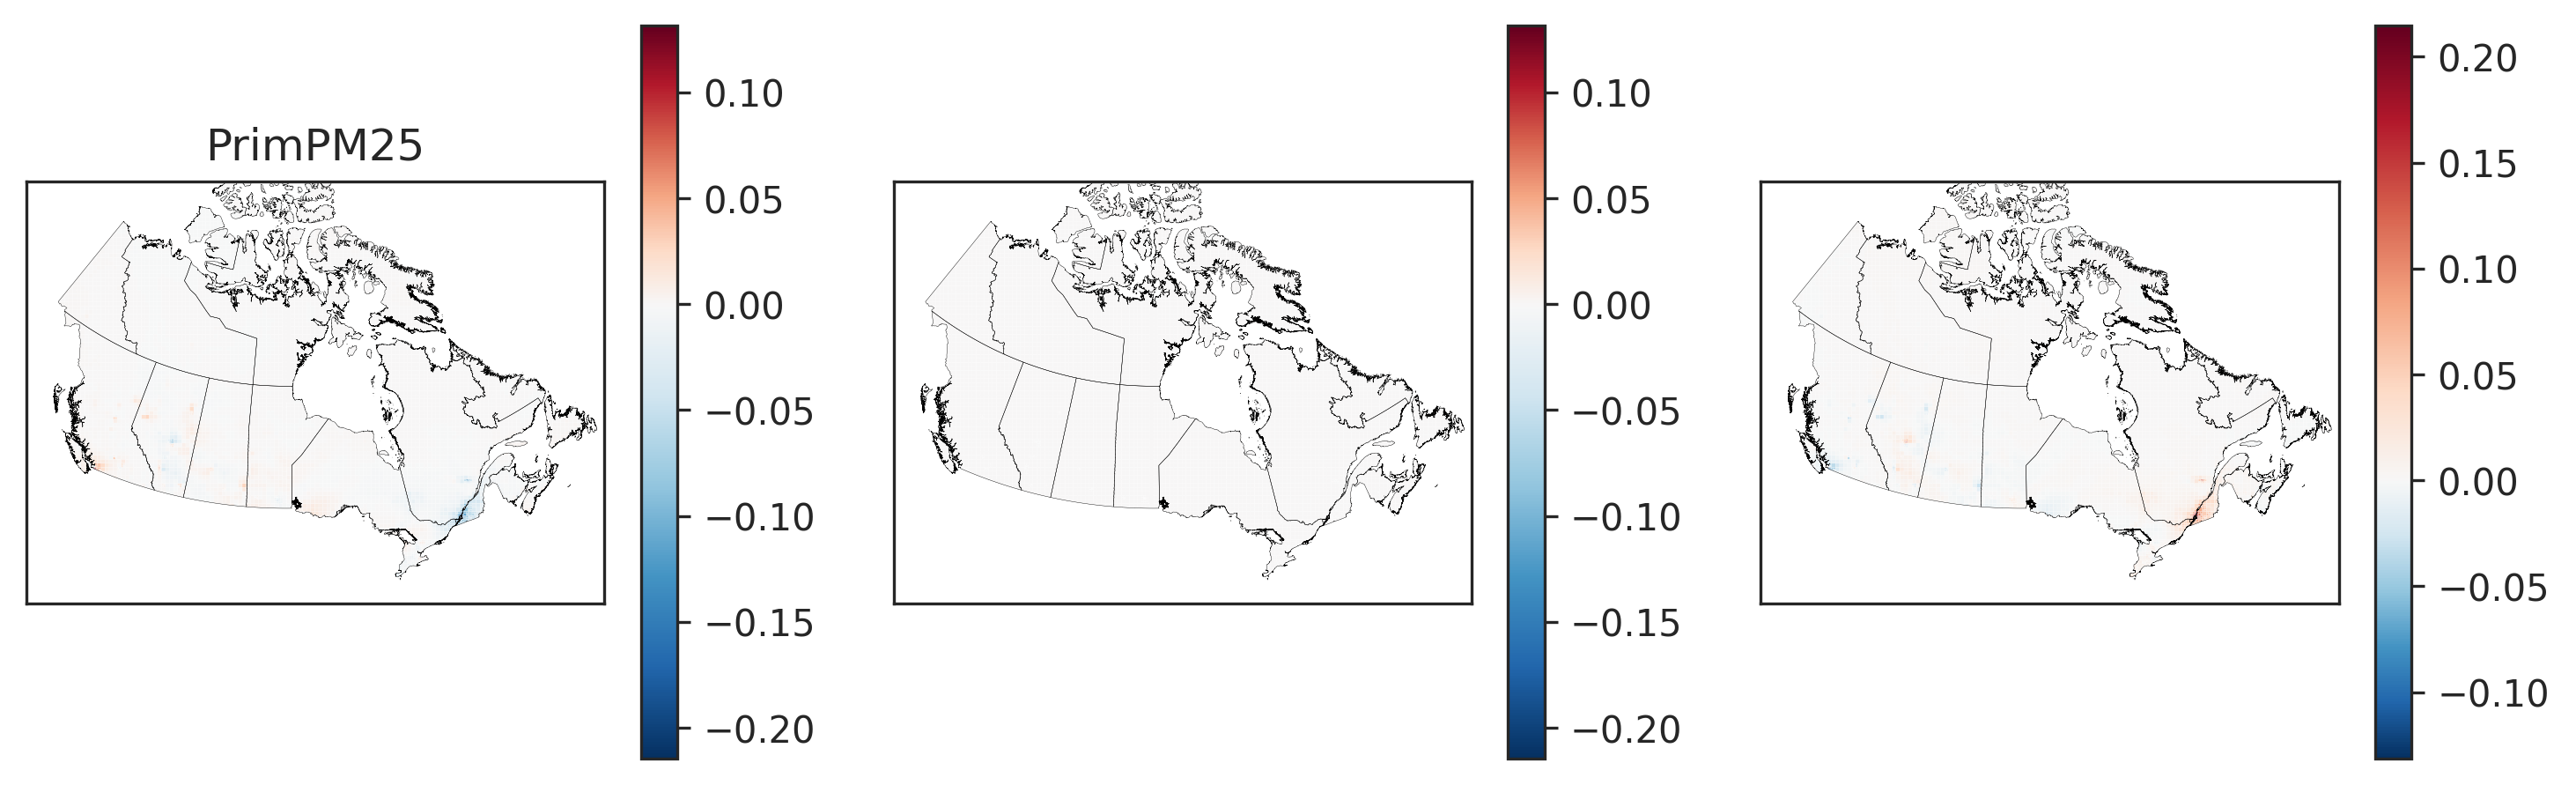

In [11]:
#Read in InMAP outputs
#fpath = 'D:/Globus Connect Personal/Data/InMAP/Outputs/' #'D:/GlobusConnect/InMap/test/Inmap_outs/'
#Evaluate baseline against preprocessor
fpath = '/home/tfmrodge/scratch/GEMMACH_data/data/Inmap_outputs/Outputs/'#Beluga
figpath='/home/tfmrodge/scratch/GEMMACH_data/Figs/'
#List of scenarios with emissions and output naming schemes
scenarios={1:['BASEGM_2015_017','BASEGM_2015_017'],2:['BAU_2020_E108','BAU_2020_105'],3:['BAU_2025_E107','BAU_2025_106'],4:['BAU_2030_E107','BAU_2030_106'],
5:['BAU_2035_E107','BAU_2035_106'],6:['BPT_2015_E002','BPT_2015_002'],7:['BPT_2015_E006','BPT_2015_006'],
8:['BPT_2015_E015','BPT_2015_015'],9:['COVID_2020_E003','COVID_2020_003'],10:['BPT_2015_E016','BPT_2015_016']}
pairs=[['BasePM25','TotalPM25'],['BasePNO3','PNO3'],['BasePNH4',
        'PNH4'],['BasePSO4','PSO4'],['BaseSOA','SOA'],['BasePrimPM25','PrimPM25']]
stats = ['RMSE', 'MeanBias', 'MeanError', 'MeanFractionalBias', 
        'MeanFractionalError', 'ModelRatio', 'Regression']
geoareas = ['Canada','British Columbia', 'Quebec', 'Nunavut', 'Prince Edward Island',
 'Saskatchewan', 'Yukon', 'Manitoba', 'Ontario', 'New Brunswick', 'Northwest Territories',
 'Alberta', 'Newfoundland and Labrador', 'Nova Scotia']
prefix='20240126_InmapOuts_'
suffix='_diff_combined.shp'
sIDs = [1] # [6,7,8]
calcdelta=True
plotouts=True #False #
loadfile=True #False #
calcstats=True
cmap=matplotlib.cm.RdBu_r
if loadfile:
    provinces = gpd.read_file('/home/tfmrodge/projects/def-agiang01/tfmrodge/InMAP_Canada/data_scripts/provinces_lcc2.gpkg')#.to_crs(inmap_outs.crs)
for sID in sIDs:
    scenario = scenarios[sID][0]#Set the scenario name 
    if loadfile:
        inmap_outs = ihf.load_inmap(fpath+prefix+scenario+suffix,basefile=None,crs='ESRI:102002',clipped=False)#'GEMMACH_BASEGM_2015_017_50x50.shp'
        #Add provinces
        inmap_outs = sjoin(inmap_outs, provinces.loc[:,['PRENAME','geometry']], how='left',predicate='intersects')
        #inmap_outs.loc[:,['BasePM25','TotalPM25']].mean()
        #Reference (GEMMACH) - INMAP
        #'Base' data is the GEMMACH output, INMAp is the other one
        if calcdelta:
            for vals in [['BasePM25','TotalPM25'],['BasePNO3','PNO3'],['BasePNH4',
                              'PNH4'],['BasePSO4','PSO4'],['BaseSOA','SOA'],['BasePrimPM25','PrimPM25']]:
                delname = 'delta_'+vals[0][4:]
                if vals[0] == 'BasePrimPM25':
                    #pdb.set_trace()
                    inmap_outs.loc[:,vals[0]] = (inmap_outs.BasePM25) - (inmap_outs.loc[:,['BasePNO3','BasePNH4','BasePSO4','BaseSOA']].sum(axis=1))
                #if sID in [6,7,8,9]:#Put in for the ones that are base - scenario (default is scenario-base)
                #    inmap_outs.loc[:,vals[0]]=-1*inmap_outs.loc[:,vals[0]]
                inmap_outs.loc[:,delname] = inmap_outs.loc[:,vals[1]] - inmap_outs.loc[:,vals[0]] 
    if plotouts:
        if sID in [6]:
            #BC
            xylims=[(-2200000,-1300000),(1190000,1800000)]
            fig = plot_pollutants(inmap_outs,provinces,legend=True,lgdshk = 0.3,lnwdth = 0.05,alpha = 1.0,
                              cmap=cmap,listvals=pairs,figpath=figpath,scenario=scenario+'_BC_'+prefix[:8],diff=True,xylims=xylims)
        if sID in [7,8]:
            #ON-QC
            xylims=[(-2200000,-1300000),(1190000,1800000)]
            fig = plot_pollutants(inmap_outs,provinces,legend=True,lgdshk = 0.3,lnwdth = 0.05,alpha = 1.0,
                              cmap=cmap,listvals=pairs,figpath=figpath,scenario=scenario+'_ONQC_'+prefix[:8],diff=True,xylims=xylims)
        xylims=[(-2579201.070414297,3165870.),(76856.48815160134,4270028.)]
        fig = plot_pollutants(inmap_outs,provinces,legend=True,lgdshk = 0.3,lnwdth = 0.05,alpha = 1.0,
                              cmap=cmap,listvals=pairs,figpath=figpath,scenario=scenario+'_'+prefix[:8],diff=True,xylims=xylims)
        fig.show()
    if calcstats:
        #popwt = None
        popwt=True #None#inmap_outs.loc[:,'TotalPop']
        #statdf function - calculates summary stats for different pairs of values in different regions
        statdf = ihf.summstats(inmap_outs,pairs,stats,geoareas,popwt=None,geoname='PRENAME',popcol='TotalPop')
        statdf.to_csv(figpath+scenario+'_summstats.csv')
        statdf = ihf.summstats(inmap_outs,pairs,stats,geoareas,popwt=True,geoname='PRENAME',popcol='TotalPop')
        statdf.to_csv(figpath+scenario+'_popsummstats.csv')
        #for fig in figs:#Returns a dict of figs
        #    fig.show()
        
    #inmap_outs.loc[:,'delta_TotPM25'] = inmap_outs.loc[:,'TotalPM25'] - inmap_outs.loc[:,'BasePM25'] 
#Correct baseline values - some were incorrectly specified in preproc file
#inmap_outs.loc[:,].mean()



In [8]:
scenario#prefix[:8] #/home/tfmrodge/scratch/GEMMACH_data/data/Inmap_outputs/Outputs/20240122_InmapOuts_BPT_2015_E002_combined.shp

'BPT_2015_E006'

In [7]:
#gpd.read_file('/home/tfmrodge/scratch/GEMMACH_data/data/Inmap_outputs/Emissions/Emissions_shp/BPT_2015_E006_area.shp')
allemissions#columns

NH3  NOx  PM25  SOx  VOC  \
0       0.0  0.0   0.0  0.0  0.0   
1       0.0  0.0   0.0  0.0  0.0   
2       0.0  0.0   0.0  0.0  0.0   
3       0.0  0.0   0.0  0.0  0.0   
4       0.0  0.0   0.0  0.0  0.0   
...     ...  ...   ...  ...  ...   
445339  0.0  0.0   0.0  0.0  0.0   
445340  0.0  0.0   0.0  0.0  0.0   
445341  0.0  0.0   0.0  0.0  0.0   
445342  0.0  0.0   0.0  0.0  0.0   
445343  0.0  0.0   0.0  0.0  0.0   

                                                 geometry PRENAME  
0       POLYGON ((2732527.967 4636950.509, 2732527.967...     NaN  
1       POLYGON ((2742530.628 4636950.509, 2742530.628...     NaN  
2       POLYGON ((2752533.289 4636950.509, 2752533.289...     NaN  
3       POLYGON ((2762535.950 4636950.509, 2762535.950...     NaN  
4       POLYGON ((2772538.610 4636950.509, 2772538.610...     NaN  
...                                                   ...     ...  
445339  POLYGON ((-3939246.810 -2014818.884, -3939246....     NaN  
445340  POLYGON ((-3929244.149 -2014818.884, -3929244....     NaN  
445341  POLYGON ((-3919241.488 -2014818.884, -3919241....     NaN  
445342  POLYGON ((-3909238.827 -2014818.884, -3909238....     NaN  
445343  POLYGON ((-3899236.166 -2014818.884, -3899236....     NaN  

[447606 rows x 7 columns]

In [ ]:
#Plot emissions
#fpath = 'D:/Globus Connect Personal/Data/InMAP/Outputs/' #'D:/GlobusConnect/InMap/test/Inmap_outs/'
#Evaluate baseline against preprocessor
fpath = '/home/tfmrodge/scratch/GEMMACH_data/data/Inmap_outputs/Emissions/Emissions_shp/Diff/'#Beluga
figpath='/home/tfmrodge/scratch/GEMMACH_data/Figs/'
#List of scenarios with emissions and output naming schemes
scenarios={1:['BASEGM_2015_017','BASEGM_2015_017'],2:['BAU_2020_E108','BAU_2020_105'],3:['BAU_2025_E107','BAU_2025_106'],4:['BAU_2030_E107','BAU_2030_106'],
5:['BAU_2035_E107','BAU_2035_106'],6:['BPT_2015_E002','BPT_2015_002'],7:['BPT_2015_E006','BPT_2015_006'],
8:['BPT_2015_E015','BPT_2015_015'],9:['COVID_2020_E003','COVID_2020_003'],10:['BPT_2015_E016','BPT_2015_016']}
pairs=[['BasePM25','TotalPM25'],['BasePNO3','PNO3'],['BasePNH4',
        'PNH4'],['BasePSO4','PSO4'],['BaseSOA','SOA'],['BasePrimPM25','PrimPM25']]
#prefix='20240122_InmapOuts_'
suffix='diff.shp'
sIDs = [6]
plotouts=True
loadfile=True #False
dopts=False
sumissions=True
cmap=matplotlib.cm.RdBu_r
provinces = gpd.read_file('/home/tfmrodge/projects/def-agiang01/tfmrodge/InMAP_Canada/data_scripts/provinces_lcc2.gpkg')#.to_crs(inmap_outs.crs)
for sID in sIDs:
    scenario = scenarios[sID][0]#Set the scenario name  /home/tfmrodge/scratch/GEMMACH_data/data/Inmap_outputs/Emissions/Emissions_shp/Diff/BPT_2015_E006_areadiff.shp
    if loadfile:
        #inmap_outs = ihf.load_inmap(fpath+prefix+scenario+suffix,basefile=None,crs='ESRI:102002',clipped=False)#'GEMMACH_BASEGM_2015_017_50x50.shp'
        areaemissions = gpd.read_file(fpath+scenario+'_area'+suffix)
        areaemissions = sjoin(areaemissions, provinces.loc[:,['PRENAME','geometry']], how='left',predicate='intersects')
        if dopts:
            majoremissions='blah'
        else:
            majoremissions=gpd.read_file(fpath+scenario+'_major'+suffix)
            majoremissions = sjoin(majoremissions, provinces.loc[:,['PRENAME','geometry']], how='left',predicate='intersects')
        allemissions = areaemissions.drop('index_right',axis=1).copy(deep=True)
        allemissions.loc[:,['NH3','NOx','PM25','SOx','VOC']]=allemissions.loc[:,['NH3','NOx','PM25','SOx','VOC']]+majoremissions.loc[:,['NH3','NOx','PM25','SOx','VOC']]
        #Add provinces
        allemissions = sjoin(allemissions, provinces.loc[:,['PRENAME','geometry']], how='left',predicate='intersects')
        #inmap_outs.loc[:,['BasePM25','TotalPM25']].mean()
        #Reference (GEMMACH) - INMAP
        #'Base' data is the GEMMACH output, INMAp is the other one 
    if plotouts:
        emisslist=[areaemissions, majoremissions,emissions] #area, major, combined
        fig = plot_emissions(emisslist,provinces,legend=True,lgdshk = 0.3,lnwdth = 0.05,
                             alpha = 1.0,cmap=cmap,listvals=pairs,figpath=figpath,scenario=scenario+'_'+prefix[:8],diff=True)
        fig.show()
        #for fig in figs:#Returns a dict of figs
        #    fig.show()
        
    #inmap_outs.loc[:,'delta_TotPM25'] = inmap_outs.loc[:,'TotalPM25'] - inmap_outs.loc[:,'BasePM25'] 
#Correct baseline values - some were incorrectly specified in preproc file
#inmap_outs.loc[:,].mean()



In [ ]:
#Loop to clip files. MIght be worth making parallel as slow. 
fpath = 'D:/Globus Connect Personal/Data/InMAP/Outputs/'#El Nino
provinces = gpd.read_file('D:\Sync\LEAP\Projects\INMAP-GEMMACH\Data\Rivkah_data\scripts\provinces_lcc2.gpkg')#.to_crs(inmap_outs.crs)
for spath in [f.path for f in os.scandir(fpath) if f.is_dir()]:
    for file in glob.glob(os.path.join(spath, "*.shp")):
        newname = file[file.find('\\')+1:-4]+'_clipped.shp'
        if spath +'\\'+ newname  not in glob.glob(os.path.join(spath, "*.shp")):
            clppd = inmap_outs = ihf.load_inmap(file,basefile=None,crs='ESRI:102002',clipped=provinces)#'GEMMACH_BASEGM_2015_017_50x50.shp'
            clppd.to_file(spath+'/'+newname)
            print('saved '+newname)
        

saved 20231020_InmapOuts_BAU_2020_E108_diff_clipped.shp
saved 20231020_InmapOuts_BAU_2025_E107_diff_clipped.shp
saved 20231020_InmapOuts_BAU_2030_E107_diff_clipped.shp
saved 20231020_InmapOuts_BAU_2035_E107_diff_clipped.shp
saved 20231020_InmapOuts_BPT_2015_E002_diff_clipped.shp
saved 20231020_InmapOuts_BPT_2015_E006_diff_clipped.shp
saved 20231020_InmapOuts_BPT_2015_E015_diff_clipped.shp
saved 20231020_InmapOuts_COVID_2020_E003_diff_clipped.shp
saved 20230915_InmapOuts_BASEGM_2015_017_clipped_clipped.shp
saved 20230915_InmapOuts_BAU_2020_E108_clipped_clipped.shp
saved 20230915_InmapOuts_BAU_2025_E107_clipped_clipped.shp
saved 20230915_InmapOuts_BAU_2030_E107_clipped_clipped.shp
saved 20230915_InmapOuts_BAU_2035_E107_clipped_clipped.shp
saved 20230915_InmapOuts_BPT_2015_E002_clipped_clipped.shp
saved 20230915_InmapOuts_BPT_2015_E006_clipped_clipped.shp
saved 20230915_InmapOuts_BPT_2015_E015_clipped_clipped.shp
saved 20230915_InmapOuts_COVID_2020_E003_clipped_clipped.shp
saved 20231127p

In [14]:
#vlim1 = [min(min(inmap_outs.loc[:,vals[0]]),min(inmap_outs.loc[:,vals[1]]))
#                     ,max(max(inmap_outs.loc[:,vals[0]]),max(inmap_outs.loc[:,vals[1]]))]
#vlim2 = [min(min(inmap_outs.loc[:,delname]),min(inmap_outs.loc[:,delname])),
#                 max(max(inmap_outs.loc[:,delname]),max(inmap_outs.loc[:,delname]))]
#vlim1
#1-vlim1[1]/(vlim1[1]+np.abs(vlim1[0]))
#1-vlim2[1]/(vlim2[1]+np.abs(vlim2[0]))
vlim1, vlim2

([-0.20275785960257103, 0.117243312299251],
 [-0.117243311396929, 0.20275786034323204])

In [18]:
# scenarios=['BAU_2020_E108','BAU_2025_E107','BAU_2030_E107',
# 'BAU_2035_E107','BPT_2015_E002','BPT_2015_E006','BPT_2015_E015','COVID_2020_E003']
vals

['BasePrimPM25', 'PrimPM25']

In [2]:
#Plot each pollutant as separate graph - each graph is 3 subplots with GEMMACH, InMAP, INMAP - GEMMACH
#fig,axs = plt.subplots(1,3,figsize = (12,12),dpi=300,sharex=True,sharey=True)
def plot_pollutants(inmap_outs,provinces,legend=True,lgdshk = 0.3,lnwdth = 0.05,alpha = 1.0,cmap='YlOrRd',listvals=None,
                    figpath='/home/tfmrodge/scratch/GEMMACH_data/Figs/',scenario='test',diff=False,xylims=None):
    #pdb.set_trace()
    if type(listvals)==type(None):
            listvals=[['BasePM25','TotalPM25'],['BasePNO3','PNO3'],['BasePNH4',
                      'PNH4'],['BasePSO4','PSO4'],['BaseSOA','SOA'],['BasePrimPM25','PrimPM25']]
    #figs ={}
    for ind,vals in enumerate(listvals):
        fig,axs = plt.subplots(1,3,figsize = (12,12),dpi=300,sharex=True,sharey=True)
        for ax in axs:
            provinces.geometry.boundary.plot(ax=ax, color=None, edgecolor='black',linewidth=0.1)
        delname = 'delta_'+vals[0][4:]
        #Set the row - 6 sets of three
        try:
            axs.shape[1]
            ax = axs[ind]
        except IndexError:
            ax = axs
        #Use the ranges to set the vlims
        if diff:
            vlim1 = [min(min(inmap_outs.loc[:,vals[0]]),min(inmap_outs.loc[:,vals[1]]))
                     ,max(max(inmap_outs.loc[:,vals[0]]),max(inmap_outs.loc[:,vals[1]]))]
            plt_cmap = ihf.shiftedColorMap(cmap, start=0, midpoint=1-vlim1[1]/(vlim1[1]+np.abs(vlim1[0])), stop=1.0, name='shiftedcmap')
        else:
            vlim1 = [0,max(max(inmap_outs.loc[:,vals[0]]),max(inmap_outs.loc[:,vals[1]]))]
            plt_cmap =cmap
        vlim2 = [min(min(inmap_outs.loc[:,delname]),min(inmap_outs.loc[:,delname])),
                 max(max(inmap_outs.loc[:,delname]),max(inmap_outs.loc[:,delname]))]
        vlim = [(vlim1),(vlim2)]
        #Define shifted colormap
        cmap2 = ihf.shiftedColorMap(matplotlib.cm.RdBu_r, start=0, midpoint=1-vlim[1][1]/(vlim[1][1]+np.abs(vlim[1][0])), stop=1.0, name='shiftedcmap')
        #Plot as reference value, predicted value, and difference
        inmap_outs.plot(vals[0],legend=legend,ax=ax[0],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=plt_cmap,vmin=vlim[0][0],vmax=vlim[0][1])
        inmap_outs.plot(vals[1],legend=legend,ax=ax[1],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=plt_cmap,vmin=vlim[0][0],vmax=vlim[0][1])
        inmap_outs.plot(delname,legend=legend,ax=ax[2],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=cmap2,vmin=vlim[1][0],vmax=vlim[1][1])
        ax[0].set_title(vals[0][4:])
        axs[0].set_xticks([]);
        axs[0].set_yticks([]);
        #Set limits
        if xylims is None:
            axs[0].set_xlim(-2579201.070414297, 3165870.);
            axs[0].set_ylim(76856.48815160134, 4270028.);
        else:
            axs[0].set_xlim(xylims[0])
            axs[0].set_ylim(xylims[1])
        #inmap_outs
        #state_outline = gpd.read_file('/Users/rivkahgf/Downloads/evaldata_v1.6.1/states.shp')
        #fig.savefig(figpath+'BaseCase_EvalPlot.pdf',format='pdf')
        fig.savefig(figpath+scenario+'_EvalPlot_'+vals[0][4:]+'.tif',format='tif')
        #figs[ind]=fig
    return fig

In [53]:
# fname='/home/tfmrodge/scratch/GEMMACH_data/data/Inmap_outputs/Emissions/Emissions_shp/Diff/BAU_2020_E108_areadiff.shp'
# #areaemissions=gpd.read_file(fname) 
# val ='NH3'
# #areaemissions.loc[areaemissions.loc[:,val]<0,:]
# negemiss = areaemissions.loc[:,[val,'geometry']].copy(deep=True)
# posemiss = areaemissions.loc[:,[val,'geometry']].copy(deep=True)
# negemiss.loc[:,val]=0.0
# posemiss.loc[:,val]=0.0
# negmask = areaemissions.loc[:,val]<0
# #Negative emissions make positive
# negemiss.loc[negmask,val] = -1*areaemissions.loc[negmask,val]
# posemiss.loc[~negmask,val] = areaemissions.loc[~negmask,val]
#posemiss.loc[posemiss.NH3>0,:]
fpath+scenario+'_'+val+'_posarea.shp'

sIDs
for sID in sIDs:
    print(sID)

2
3
4
5
6
7
8
9


In [3]:
#Plot each emission as separate graph - area, major, combined
#fig,axs = plt.subplots(1,3,figsize = (12,12),dpi=300,sharex=True,sharey=True)
def plot_emissions(emissions,provinces,legend=True,lgdshk = 0.3,lnwdth = 0.05,alpha = 1.0,cmap='YlOrRd',listvals=None,
                    figpath='/home/tfmrodge/scratch/GEMMACH_data/Figs/',scenario='test',diff=False,xylims=None):
    #pdb.set_trace()
    if type(listvals)==type(None):
            listvals=['NH3','NOx','PM25','SOx','VOC']
    #figs ={}
    for ind,val in enumerate(listvals):
        if len(emissions) ==3:#If emissions is a list of dataframes plot as area, major, combined
            fig,axs = plt.subplots(1,3,figsize = (12,12),dpi=300,sharex=True,sharey=True)
            axs=np.reshape(axs,3)
            area=emissions[0]
            major=emissions[1]
            esum=emissions[2]
        else:
            fig,axs = plt.subplots(2,3,figsize = (12,12),dpi=300,sharex=True,sharey=True)
            axs=np.reshape(axs,6)
            esum=emissions
        for ax in axs:
            provinces.geometry.boundary.plot(ax=ax, color=None, edgecolor='black',linewidth=0.1)
        #Use the ranges to set the vlims and the cmap if it needs to be shifted
        if diff:
            vlim = [min(min(esum.loc[:,val]),min(esum.loc[:,val]))
                     ,max(max(esum.loc[:,val]),max(esum.loc[val]))]
            cmap = shiftedColorMap(cmap, start=0, midpoint=1-vlim[1]/(vlim[1]+np.abs(vlim[0])), stop=1.0, name='shiftedcmap')
        else:
            vlim = [0,max(max(esum.loc[:,val]),max(esum.loc[:,val]))]
        #Plot as area, major, combined for each pollutant
        if len(emissions)==3:
            area.plot(val,legend=legend,ax=axs[0],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=cmap,vmin=vlim[0][0],vmax=vlim[0][1])
            major.plot(val,legend=legend,ax=axs[1],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=cmap,vmin=vlim[0][0],vmax=vlim[0][1])
            esum.plot(val,legend=legend,ax=axs[2],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=cmap,vmin=vlim[0][0],vmax=vlim[0][1])
        else:
            esum.plot(val,legend=legend,ax=axs[ind],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=cmap,vmin=vlim[0][0],vmax=vlim[0][1])

        axs[ind].set_title(val[0][4:])
    axs[0].set_xticks([]);
    axs[0].set_yticks([]);
    #Set limits
    if xylims is None:
        axs[0].set_xlim(-2579201.070414297, 3165870.);
        axs[0].set_ylim(76856.48815160134, 4270028.);
    else:
        axs[0].set_xlim(xylims[0])
        axs[0].set_ylim(xylims[1])
    fig.savefig(figpath+scenario+'_EmissPlot_'+val+'.tif',format='tif')
        #figs[ind]=fig
    return fig

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

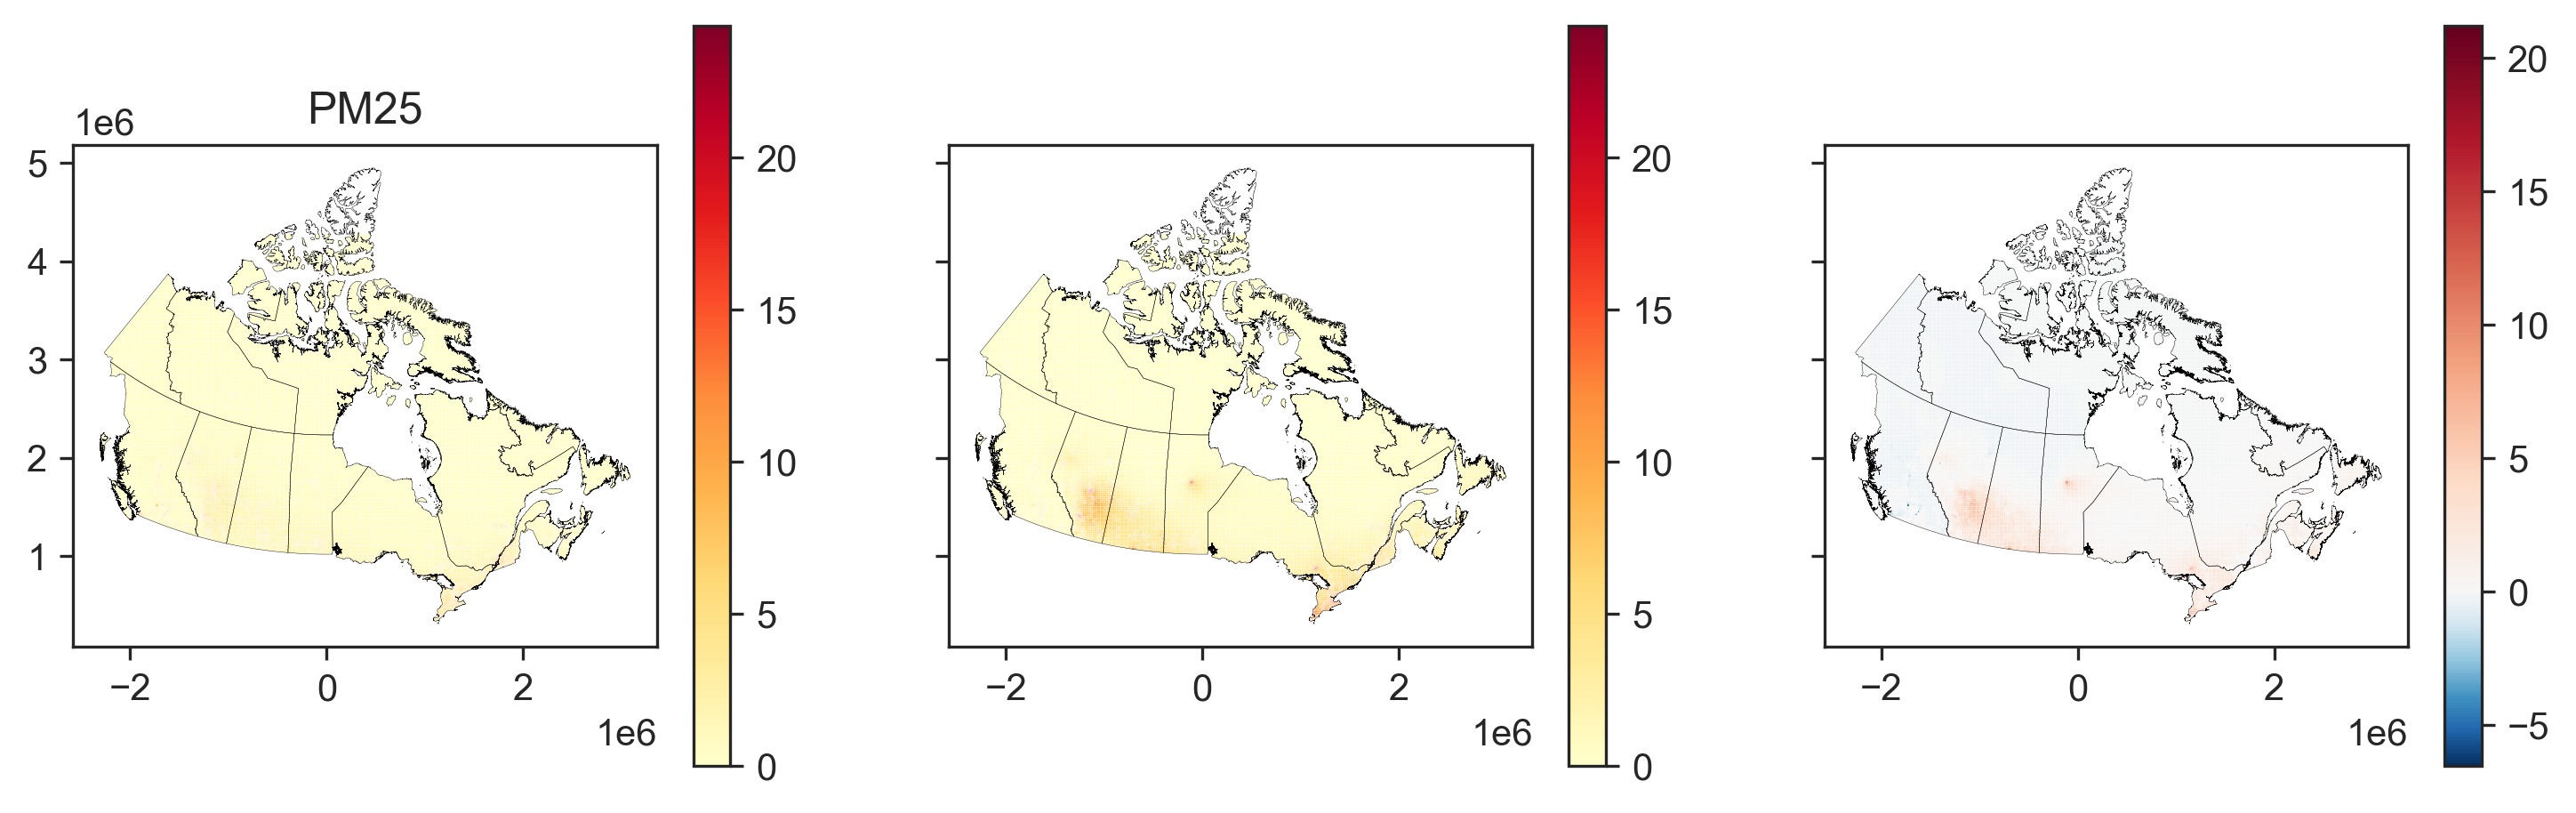

In [270]:
fig,axs = plt.subplots(1,3,figsize = (12,12),dpi=300,sharex=True,sharey=True)
legend=True
lgdshk = 0.3
lnwdth = 0.05
alpha = 1.0
cmap='YlOrRd'
#pdb.set_trace()
for ax in axs:
    try:
        for sax in ax:
            #provinces.plot(ax=ax)
            provinces.geometry.boundary.plot(ax=sax, color=None, edgecolor='black',linewidth=0.1)
    except TypeError:
        provinces.geometry.boundary.plot(ax=ax, color=None, edgecolor='black',linewidth=0.1)
for ind,vals in enumerate([['BasePM25','TotalPM25']]):#enumerate([['BasePM25','TotalPM25'],['BasePNO3','PNO3'],['BasePNH4',
#                  'PNH4'],['BasePSO4','PSO4'],['BaseSOA','SOA'],['BasePrimPM25','PrimPM25']]):
    delname = 'delta_'+vals[0][4:]
    #Set the row - 6 sets of three
    try:
        axs.shape[1]
        ax = axs[ind]
    except IndexError:
        ax = axs
    #Use the ranges to set the vlims
    vlim1 = [0,max(max(inmap_outs.loc[:,vals[0]]),max(inmap_outs.loc[:,vals[1]]))]
    vlim2 = [min(min(inmap_outs.loc[:,delname]),min(inmap_outs.loc[:,delname])),
             max(max(inmap_outs.loc[:,delname]),max(inmap_outs.loc[:,delname]))]
    vlim = [(vlim1),(vlim2)]
    #Define shifted colormap
    cmap2 = ihf.shiftedColorMap(matplotlib.cm.RdBu_r, start=0, midpoint=1-vlim[1][1]/(vlim[1][1]+np.abs(vlim[1][0])), stop=1.0, name='shiftedcmap')
    #Plot as reference value, predicted value, and difference
    inmap_outs.plot(vals[0],legend=legend,ax=ax[0],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=cmap,vmin=vlim[0][0],vmax=vlim[0][1])
    inmap_outs.plot(vals[1],legend=legend,ax=ax[1],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=cmap,vmin=vlim[0][0],vmax=vlim[0][1])
    inmap_outs.plot(delname,legend=legend,ax=ax[2],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=cmap2,vmin=vlim[1][0],vmax=vlim[1][1])
    ax[0].set_title(vals[0][4:])
axs[0,0].set_xticks([]);
axs[0,0].set_yticks([]);
#Set limits to Canada
axs[0,0].set_xlim(-2579201.070414297, 3165870.);
axs[0,0].set_ylim(76856.48815160134, 4270028.);
#inmap_outs
#state_outline = gpd.read_file('/Users/rivkahgf/Downloads/evaldata_v1.6.1/states.shp')
figpath = 'D:/Sync/LEAP/Projects/INMAP-GEMMACH/Documents/Figs/'
#fig.savefig(figpath+'BaseCase_EvalPlot.pdf',format='pdf')
#fig.savefig(figpath+'BaseCase_EvalPlot.tif',format='tif')

In [164]:
#Now, lets calculate some stats! 
importlib.reload(ihf)
#import pdb
stat = 'RMSE'
pairs = [['BasePM25','TotalPM25'],['BasePNO3','PNO3'],['BasePNH4',
                  'PNH4'],['BasePSO4','PSO4'],['BaseSOA','SOA'],['BasePrimPM25','PrimPM25']]
stats = ['RMSE', 'MeanBias', 'MeanError', 'MeanFractionalBias', 
        'MeanFractionalError', 'ModelRatio', 'Regression']
geoarea = ['Canada']
statdf = pd.DataFrame(columns=['Location']+stats[:-1])
popwt = None
for geoarea in geoareas:
    for pair in pairs:
        statdf.loc[pair[0][4:],'Location'] = geoarea
        for stat in stats:
            if stat != 'Regression':
                statdf.loc[pair[0][4:],stat] = ihf.calcstat(stat,inmap_outs.loc[:,pair[0]],inmap_outs.loc[:,pair[1]],popwt)
            else:
                m,r2 = ihf.calcstat(stat,inmap_outs.loc[:,pair[0]],inmap_outs.loc[:,pair[1]],popwt)
                statdf.loc[pair[0][4:],'Slope']=m
                statdf.loc[pair[0][4:],'r²']=r2
        #pdb.set_trace()
    #print(pair[0])
statdf

D:\Sync\LEAP\Projects\INMAP-GEMMACH\Data\Rivkah_data\scripts\inmap_funcs.py:198: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m,r2 = res.params[0],res.rsquared
D:\Sync\LEAP\Projects\INMAP-GEMMACH\Data\Rivkah_data\scripts\inmap_funcs.py:198: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m,r2 = res.params[0],res.rsquared
D:\Sync\LEAP\Projects\INMAP-GEMMACH\Data\Rivkah_data\scripts\inmap_funcs.py:198: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Location      RMSE  MeanBias MeanError MeanFractionalBias  \
PM25      Nova Scotia  1.761029  0.494408  0.960317          -0.547062   
PNO3      Nova Scotia  0.504611 -0.023966  0.287676          -0.587323   
PNH4      Nova Scotia  0.383692  0.124704  0.204154          -0.871324   
PSO4      Nova Scotia  0.708843  0.055844  0.341783           -0.70751   
SOA       Nova Scotia  0.268434 -0.148061  0.154903          -1.648759   
PrimPM25  Nova Scotia  0.931252  0.485887  0.523241           3.170608   

         MeanFractionalError ModelRatio     Slope        r²  
PM25                0.979243   0.979578  0.526099  0.769499  
PNO3                0.871528   0.796144  0.796620  0.734580  
PNH4                1.445741   1.079298  0.327563  0.740828  
PSO4                1.092136    0.88813  0.307253  0.397858  
SOA                 1.662408   0.132786  1.896977  0.442764  
PrimPM25            3.392909  20.637308  0.394231  0.239901

In [126]:
#provinces
import time
inmap_outs = inmap_outs.drop(['index_right','PRENAME'],axis=1)
tstart = time.time()
inmap_outs = sjoin(inmap_outs, provinces.loc[:,['PRENAME','geometry']], how='left',predicate='within') #'intersects'
twithin= time.time()-tstart
inmap_outs = inmap_outs.drop(['index_right','PRENAME'],axis=1)
tstart = time.time()
inmap_outs = sjoin(inmap_outs, provinces.loc[:,['PRENAME','geometry']], how='left',predicate='intersects')
tintersect = time.time()-tstart
[twithin,tintersect]
#provinces.loc[:,['PRENAME','geometry']]

[220.77017998695374, 339.2808244228363]

In [161]:
#pltdata = pltdata[inmap_outs1.PRENAME=='Ontario'] 
#inmap_outs1.loc[inmap_outs1.PRENAME=='Ontario']
#pltdata = inmap_outs1.loc[inmap_outs1.PRENAME=='Ontario']
#inmap_outs.drop(['index_right','PRENAME'],axis=1)
#inmap_outs.loc[inmap_outs.PRENAME=='Ontario']
# geoarea = 'Ontario'
# pltdata = inmap_outs.loc[inmap_outs.PRENAME==geoarea]
# pltdata
#pd.concat(statdfs.values()).reset_index()#.concat()#.loc[pair[0][4:],'Location']# = geoarea
#pd.concat(statdfs)
statdf

index     Location      RMSE  MeanBias MeanError MeanFractionalBias  \
0       PM25       Canada  4.138231  2.583669  2.979658           0.356608   
1       PNO3       Canada   0.48616  0.050726  0.318422           0.059567   
2       PNH4       Canada  0.859905  0.652481  0.656178           0.703403   
3       PSO4       Canada   1.65628   1.17945  1.190684           0.801485   
4        SOA       Canada  0.234875  0.043966   0.16053          -0.228956   
..       ...          ...       ...       ...       ...                ...   
79      PNO3  Nova Scotia   0.34211  0.296184  0.298578           0.530815   
80      PNH4  Nova Scotia    0.3559  0.345878  0.345878           1.238416   
81      PSO4  Nova Scotia  0.648725  0.470477  0.470477           0.810156   
82       SOA  Nova Scotia  0.070084 -0.067969  0.067969           -0.82375   
83  PrimPM25  Nova Scotia  0.448037  0.374065  0.374603           1.389782   

   MeanFractionalError ModelRatio     Slope        r²  
0             0.439768   1.614816  0.645417  0.877297  
1             0.251717   1.144441  0.929389  0.916756  
2              0.75408   2.364581  0.375523  0.914122  
3             0.871976   2.772569  0.265874  0.816534  
4             0.584481   1.000545  0.625248  0.780334  
..                 ...        ...       ...       ...  
79            0.535801   1.805734  0.551705  0.930494  
80            1.238416   4.428526  0.222003  0.949259  
81            0.810156   2.598599  0.281461  0.778494  
82             0.82375    0.43065  2.061411  0.905055  
83            1.390577   7.543506  0.364227  0.450969  

[84 rows x 10 columns]

In [15]:
#Now, lets calculate some stats! This will call the summstats function to run through
#provinces for each pair of test vs est values you want to look at, for each stat you want
importlib.reload(ihf)
#import pdb
stat = 'RMSE'
pairs = [['BasePM25','TotalPM25'],['BasePNO3','PNO3'],['BasePNH4',
                  'PNH4'],['BasePSO4','PSO4'],['BaseSOA','SOA'],['BasePrimPM25','PrimPM25']]
stats = ['RMSE', 'MeanBias', 'MeanError', 'MeanFractionalBias', 
        'MeanFractionalError', 'ModelRatio', 'Regression']
geoareas = ['Canada','British Columbia', 'Quebec', 'Nunavut', 'Prince Edward Island',
 'Saskatchewan', 'Yukon', 'Manitoba', 'Ontario', 'New Brunswick', 'Northwest Territories',
 'Alberta', 'Newfoundland and Labrador', 'Nova Scotia']
#popwt = None
popwt=True #None#inmap_outs.loc[:,'TotalPop']
#statdf function - calculates summary stats for different pairs of values in different regions
statdf = ihf.summstats(inmap_outs,pairs,stats,geoareas,popwt=None,geoname='PRENAME',popcol='TotalPop')
figpath = 'D:/Sync/LEAP/Projects/INMAP-GEMMACH/Documents/Figs/'
statdf#.to_csv(figpath+'BaseGM_20km_popwt.csv')

/lustre03/project/6016368/tfmrodge/InMAP_Canada/data_scripts/inmap_funcs.py:250: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m,r2 = res.params[0],res.rsquared
/lustre03/project/6016368/tfmrodge/InMAP_Canada/data_scripts/inmap_funcs.py:250: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m,r2 = res.params[0],res.rsquared
/lustre03/project/6016368/tfmrodge/InMAP_Canada/data_scripts/inmap_funcs.py:250: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

index     Location      RMSE  MeanBias MeanError MeanFractionalBias  \
0       PM25       Canada  0.037073  -0.01231  0.015765          -1.783754   
1       PNO3       Canada  0.007869 -0.001409  0.003729          -1.660244   
2       PNH4       Canada  0.004355 -0.001714  0.002141               -2.0   
3       PSO4       Canada  0.004068 -0.002307  0.002839               -2.0   
4        SOA       Canada  0.002827 -0.001543  0.001867               -2.0   
..       ...          ...       ...       ...       ...                ...   
79      PNO3  Nova Scotia  0.007919 -0.006596  0.006596          -0.862673   
80      PNH4  Nova Scotia  0.000668 -0.000626  0.000626               -2.0   
81      PSO4  Nova Scotia  0.002143 -0.001765  0.001808               -2.0   
82       SOA  Nova Scotia   0.00258 -0.002419  0.002419               -2.0   
83  PrimPM25  Nova Scotia  0.006095 -0.003268  0.004713          -2.000003   

   MeanFractionalError ModelRatio          Slope        r²  
0              0.99396   0.071429       2.499348  0.611035  
1             0.398011   0.139771       1.120583  0.825258  
2             1.135207        0.0       0.000000  0.000000  
3             1.207789        0.0       0.000000  0.000000  
4             1.263111        0.0       0.000000  0.000000  
..                 ...        ...            ...       ...  
79            0.862673   0.426204       2.498086  0.804013  
80                 2.0        0.0       0.000000  0.000000  
81            1.824176        0.0       0.000000  0.000000  
82                 2.0        0.0       0.000000  0.000000  
83            0.813195  -0.000001  114655.057749  0.000659  

[84 rows x 10 columns]

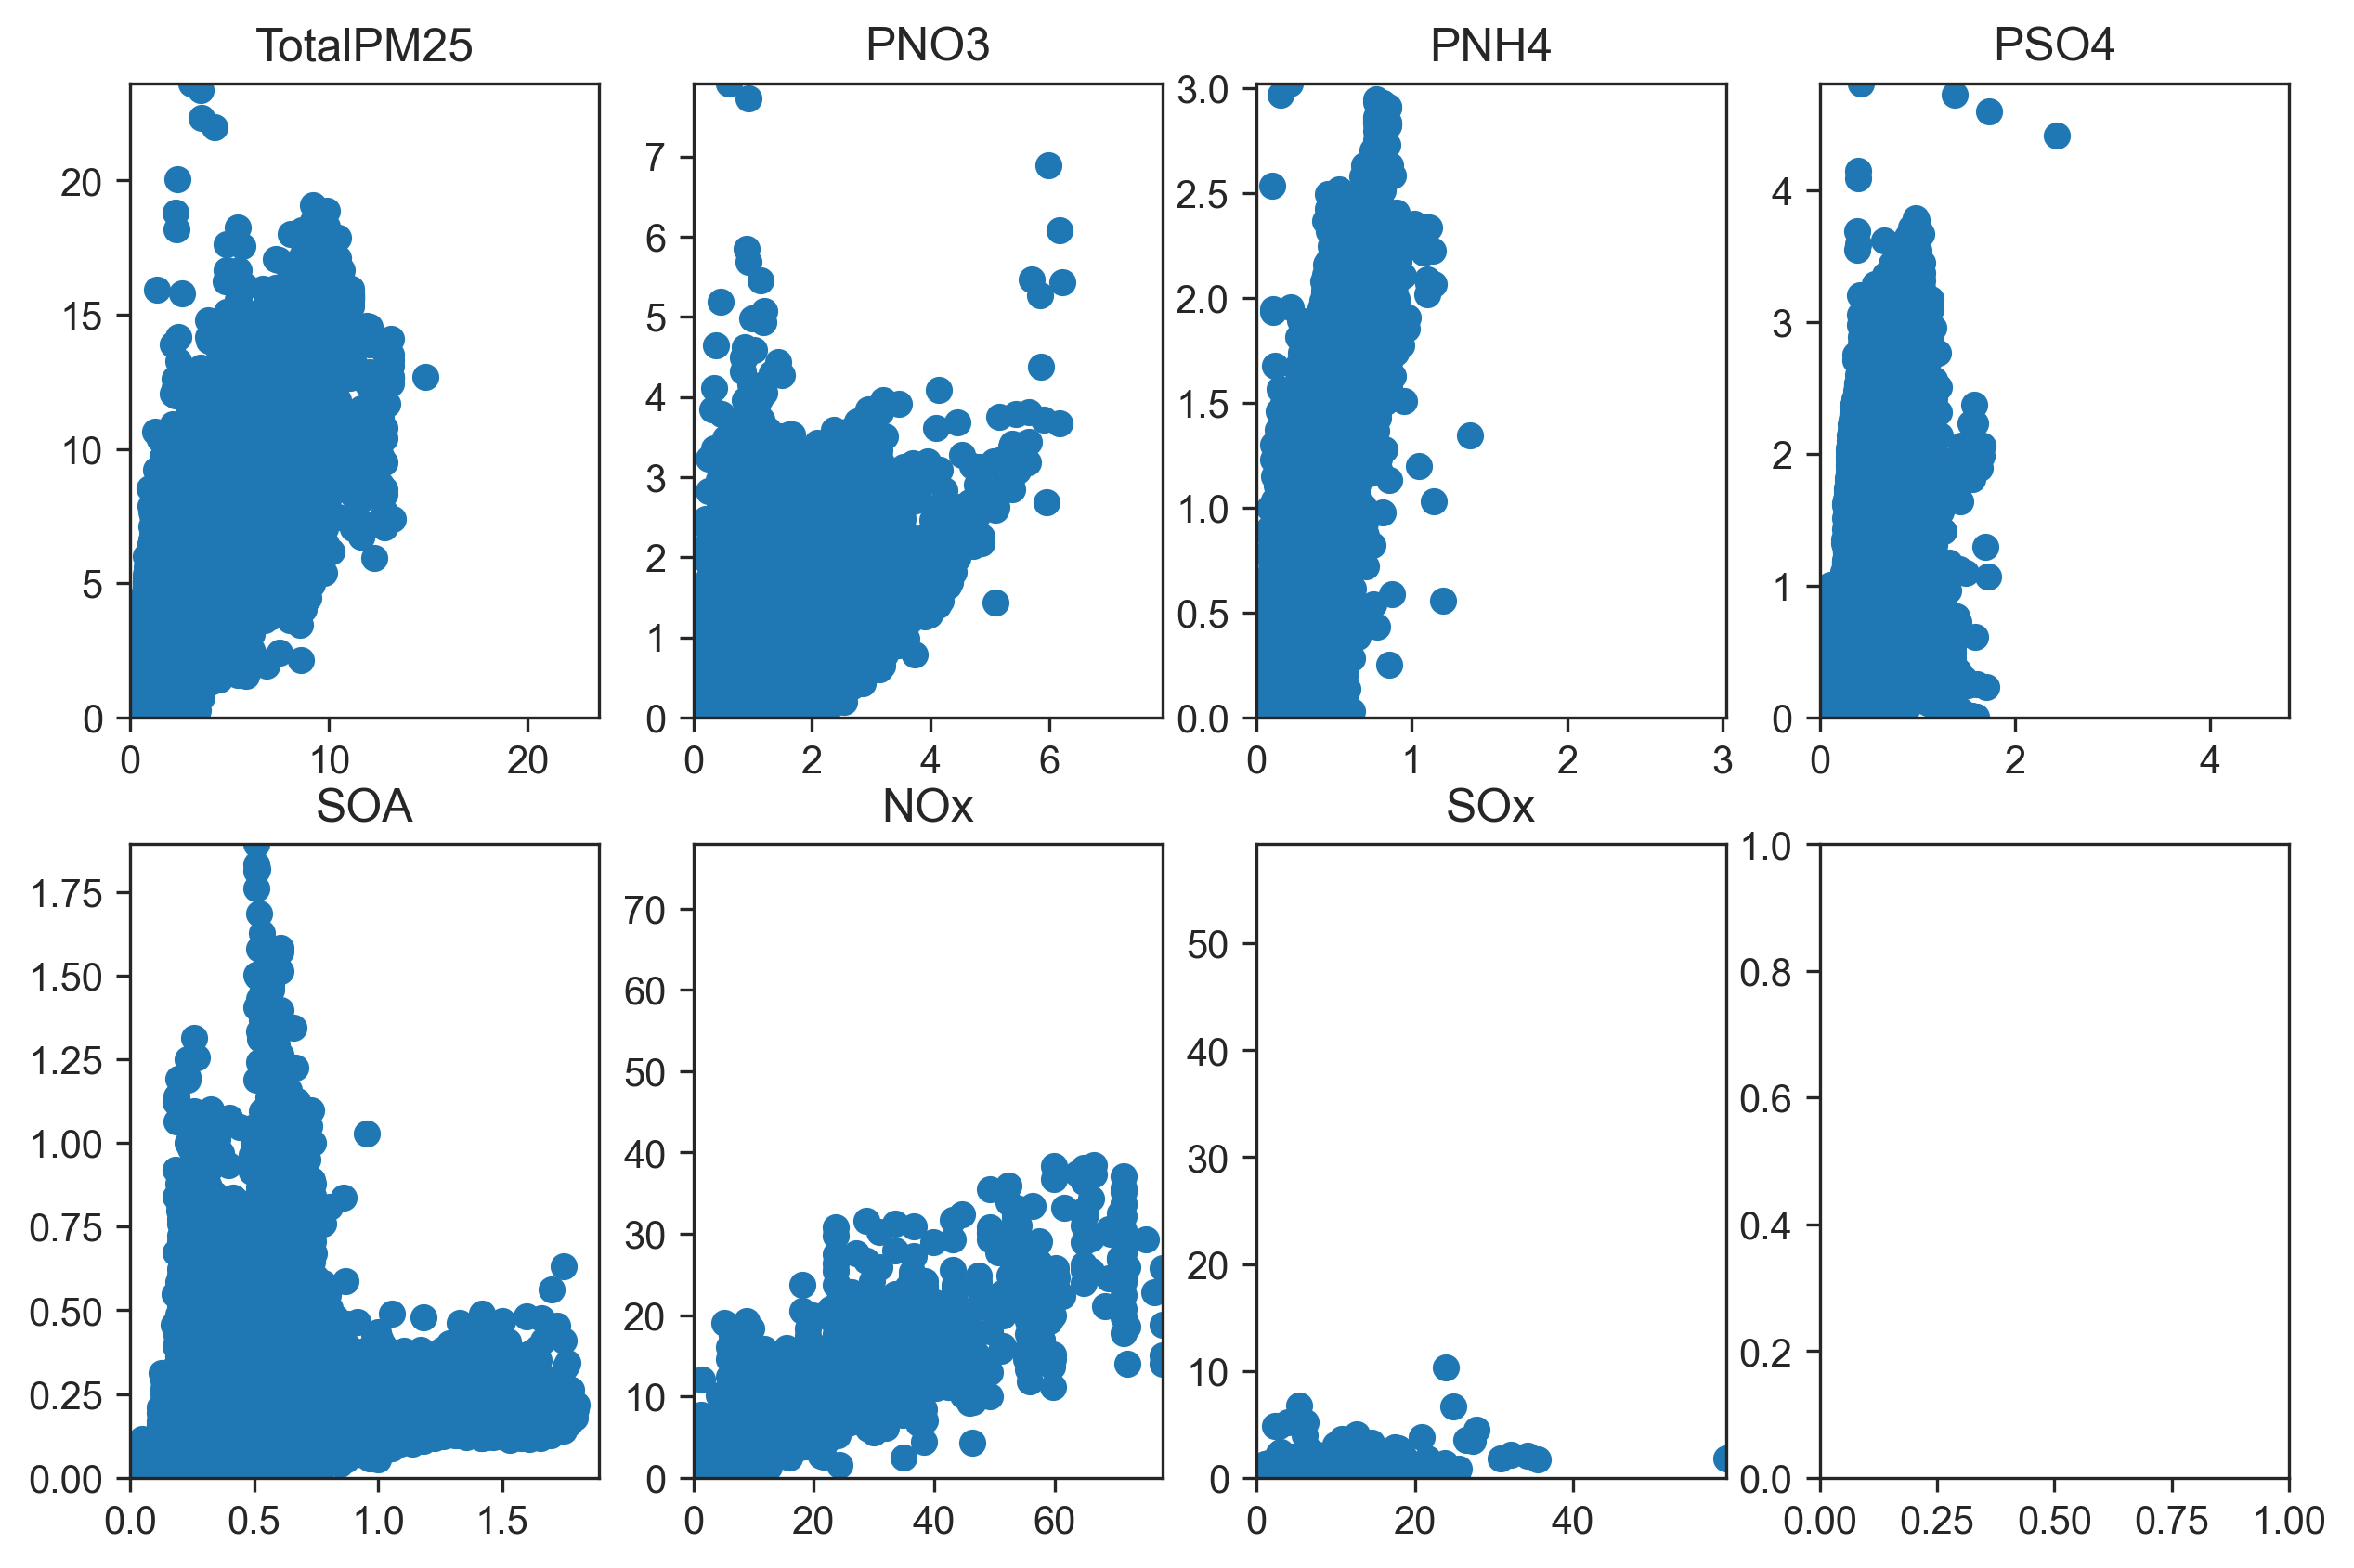

In [6]:
#inmap_outs.columns
fig,axs = plt.subplots(2,4,figsize = (10,6.5),dpi=300,sharex=False,sharey=False)
axs = np.hstack(axs) #Turn linear
pairs = [('BasePM25','TotalPM25'),('BasePNO3','PNO3'),('BasePNH4','PNH4'),('BasePSO4','PSO4'),
         ('BaseSOA','SOA'),('BaseNOx', 'NOx'),('BaseSOx','SOx')]
for ind,pair in enumerate(pairs):
    axs[ind].scatter(inmap_outs.loc[:,pair[0]],inmap_outs.loc[:,pair[1]])
    maxval = np.max([inmap_outs.loc[:,pair[0]].max(),inmap_outs.loc[:,pair[1]].max()])
    axs[ind].set_ylim(0,maxval);
    axs[ind].set_xlim(0,maxval);
    axs[ind].set_title(pair[1])

In [201]:
#df.loc[:,'latlon'] = df.lat.astype(str)+', '+(df.lon).astype(str)
# df.loc[:,'latlon']
# df.loc[:,['latlon','obs','lat','lon']].groupby('latlon').mean()

In [272]:
#Model-Observation Testing of BASEGM PM2.5
# geoareas = {'Canada':'CAN','British Columbia':'BC', 'Quebec':'QC',
#  'Saskatchewan':'SK', 'Yukon':'YT', 'Manitoba':'MB', 'Ontario':'ON', 'Northwest Territories':'NT',
#  'Alberta':'AB'}
#Load in the data
loadfile=True
calcdelta=True

#scenario = scenarios[sID][0]#Set the scenario name 
if loadfile:
    fpath = 
    inmap_outs = ihf.load_inmap(fpath+prefix+scenario+suffix,basefile=None,crs='ESRI:102002',clipped=False)#'GEMMACH_BASEGM_2015_017_50x50.shp'
    provinces = gpd.read_file('/home/tfmrodge/projects/def-agiang01/tfmrodge/InMAP_Canada/data_scripts/provinces_lcc2.gpkg')#.to_crs(inmap_outs.crs)
    #Add provinces
    inmap_outs = sjoin(inmap_outs, provinces.loc[:,['PRENAME','geometry']], how='left',predicate='intersects')
    #inmap_outs.loc[:,['BasePM25','TotalPM25']].mean()
    #Reference (GEMMACH) - INMAP
    #'Base' data is the GEMMACH output, INMAp is the other one
    if calcdelta:
        for vals in [['BasePM25','TotalPM25']]:
            delname = 'delta_'+vals[0][4:]
            if vals[0] == 'BasePrimPM25':
                #pdb.set_trace()
                inmap_outs.loc[:,vals[0]] = (inmap_outs.BasePM25) - (inmap_outs.loc[:,['BasePNO3','BasePNH4','BasePSO4','BaseSOA']].sum(axis=1))
            #if sID in [6,7,8,9]:#Put in for the ones that are base - scenario (default is scenario-base)
            #    inmap_outs.loc[:,vals[0]]=-1*inmap_outs.loc[:,vals[0]]
            inmap_outs.loc[:,delname] = inmap_outs.loc[:,vals[1]] - inmap_outs.loc[:,vals[0]] 
    evalpath = 'D:/Sync/LEAP/Projects/INMAP-GEMMACH/Data/From_ECCC/ECCC_EvalData/d002/'
    df = pd.read_csv(evalpath+'CAN_PM2.5_full.csv')
#Put it all into an average for each point
df.loc[:,'latlon'] = df.lat.astype(str)+', '+(df.lon).astype(str)
obsdf = df.loc[:,['latlon','obs','lat','lon']].groupby('latlon').mean()
#Make it a geodataframe
obsgdf = gpd.GeoDataFrame(
    obsdf, geometry=gpd.points_from_xy(obsdf.lon, obsdf.lat), crs="EPSG:4326").to_crs('ESRI:102002')
obsgdf = obsgdf.reset_index().drop('latlon',axis=1)
#Now, we are going to find the corresponding pixels from InMAP with sjoin
obsgdf = sjoin(obsgdf, inmap_outs.loc[:,['BasePM25','TotalPM25','geometry','PRENAME','TotalPop']], how='left',predicate='intersects')
#summstats(df,pairs,stats,geoareas,popwt=None)
#Clean it up
obsgdf = obsgdf.rename(columns={"obs": "BasePMobs"})
obsgdf = obsgdf.dropna()
#Run the stats! Gotta do each pair at a time right now as it doesn't know how to deal with having two references the same
#Total = InMap, Base = GEMMACH
pairs =[['BasePMobs','TotalPM25']] #[['BasePMobs','BasePM25']] # ,['BasePMobs','BasePM25']] #[]#, #
stats = ['n','RMSE', 'MeanBias', 'MeanError', 'MeanFractionalBias', 
        'MeanFractionalError', 'ModelRatio','Regression'] #['RMSE']#
#Truncated list, only what is present
# geoareas = ['Canada','Ontario','Nova Scotia', 'New Brunswick', 'Quebec',
#        'Prince Edward Island', 'Newfoundland and Labrador',
#        'British Columbia', 'Saskatchewan', 'Alberta', 'Manitoba',
#        'Northwest Territories', 'Yukon', 'Nunavut']
# popwt = True #None # True #
# ihf.summstats(obsgdf,pairs,stats,geoareas,popwt=popwt)
#Truncated list, only what is present
remap = {'Canada':'Canada','Ontario':'Ontario','Nova Scotia':'Atlantic', 'New Brunswick':'Atlantic', 'Quebec':'Quebec',
       'Prince Edward Island':'Atlantic', 'Newfoundland and Labrador':'Atlantic',
       'British Columbia':'British Columbia', 'Saskatchewan':'Prairies', 'Alberta':'Prairies', 'Manitoba':'Prairies',
       'Northwest Territories':'North', 'Yukon':'North', 'Nunavut':'North'}
obsgdf.loc[:,'PRENAME']=obsgdf.PRENAME.map(remap)
geoareas = ['Canada','British Columbia','Prairies','Ontario','Quebec','Atlantic','North']
popwt = None # True # True #
ihf.summstats(obsgdf,pairs,stats,geoareas,popwt=popwt)

D:\Sync\LEAP\Projects\INMAP-GEMMACH\Data\Rivkah_data\scripts\inmap_funcs.py:250: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m,r2 = res.params[0],res.rsquared
D:\Sync\LEAP\Projects\INMAP-GEMMACH\Data\Rivkah_data\scripts\inmap_funcs.py:250: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m,r2 = res.params[0],res.rsquared
D:\Sync\LEAP\Projects\INMAP-GEMMACH\Data\Rivkah_data\scripts\inmap_funcs.py:250: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

index          Location    n      RMSE  MeanBias MeanError  \
0  PMobs            Canada  211   4.31812 -0.374218  3.399596   
1  PMobs  British Columbia   46   4.70546 -2.151445   4.02441   
2  PMobs          Prairies   48  5.005367  0.331311  3.587817   
3  PMobs           Ontario   42   4.84079  3.040476  3.853502   
4  PMobs            Quebec   46  2.738421   -0.6837  2.303984   
5  PMobs          Atlantic   24  3.027868 -2.680197  2.680197   
6  PMobs             North    5  5.728531 -5.564304  5.564304   

  MeanFractionalBias MeanFractionalError ModelRatio      Slope        r²  
0           -0.32579             0.63993   0.920063   0.698653  0.660349  
1          -0.668625            0.909101   0.706219   0.801894  0.454104  
2          -0.248012            0.603773   1.021012   0.612902  0.655385  
3           0.271572             0.43072   1.448123   0.595815  0.876850  
4          -0.234049             0.42207   0.871915   0.923228  0.840247  
5          -0.730128            0.730128   0.478918   2.132938  0.898140  
6          -1.839402            1.839402   0.043095  17.318543  0.562607

In [276]:
obsgdf#.plot('BasePMobs',legend=True)

BasePMobs        lat         lon                          geometry  \
0     9.101216  42.292889  -83.073135    POINT (1090286.845 370986.691)   
1     7.850798  42.315777  -83.043671    POINT (1092227.966 374041.625)   
2     6.860508  42.403694  -82.208305    POINT (1159556.886 398175.651)   
3     6.780488  42.672085  -81.162888    POINT (1239160.250 447160.296)   
4     6.730734  42.974461  -81.200858    POINT (1228351.651 480069.400)   
..         ...        ...         ...                               ...   
202   7.241385  60.004486 -111.893377   POINT (-864710.779 2339383.265)   
203   6.700169  60.719686 -135.058683  POINT (-1978201.765 2917819.363)   
204   4.205143  62.452084 -114.364031   POINT (-921884.694 2632525.086)   
205   6.451887  63.751619  -68.522433   POINT (1299306.658 2921099.055)   
206   4.300037  68.356994 -133.714063  POINT (-1461736.625 3584878.776)   

     index_right  BasePM25  TotalPM25  PRENAME      TotalPop  
0           50.0  9.087276  12.169340  Ontario   6701.958062  
1           62.0  9.447878  11.870174  Ontario    422.829467  
2          172.0  4.685368  10.389791  Ontario  18422.838743  
3          207.0  4.279532   9.863684  Ontario   3802.393951  
4          241.0  6.590497   9.655525  Ontario  42045.197068  
..           ...       ...        ...      ...           ...  
202      11187.0  0.414796   0.143047    North   2288.147286  
203      12151.0  0.439288   0.174602    North    251.443395  
204      11390.0  1.233779   0.491272    North  11695.821528  
205       8877.0  0.114313   0.122909    North   7740.074005  
206      12909.0  0.283814   0.145269    North   3021.179342  

[211 rows x 9 columns]

<Axes: >

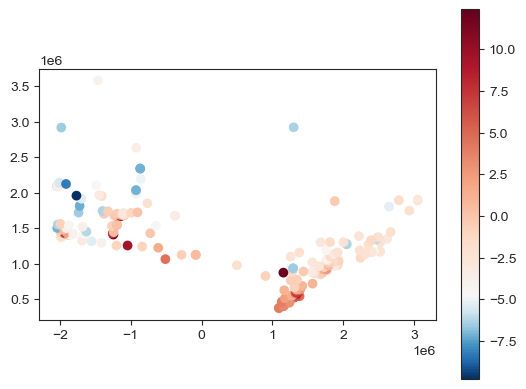

In [278]:
obsgdf.loc[:,'del_gem'] = obsgdf.loc[:,'BasePM25'] - obsgdf.loc[:,'BasePMobs']
obsgdf.loc[:,'del_inmap'] = obsgdf.loc[:,'TotalPM25'] - obsgdf.loc[:,'BasePMobs']
obsgdf.plot('del_inmap',legend=legend,cmap=cmap2)

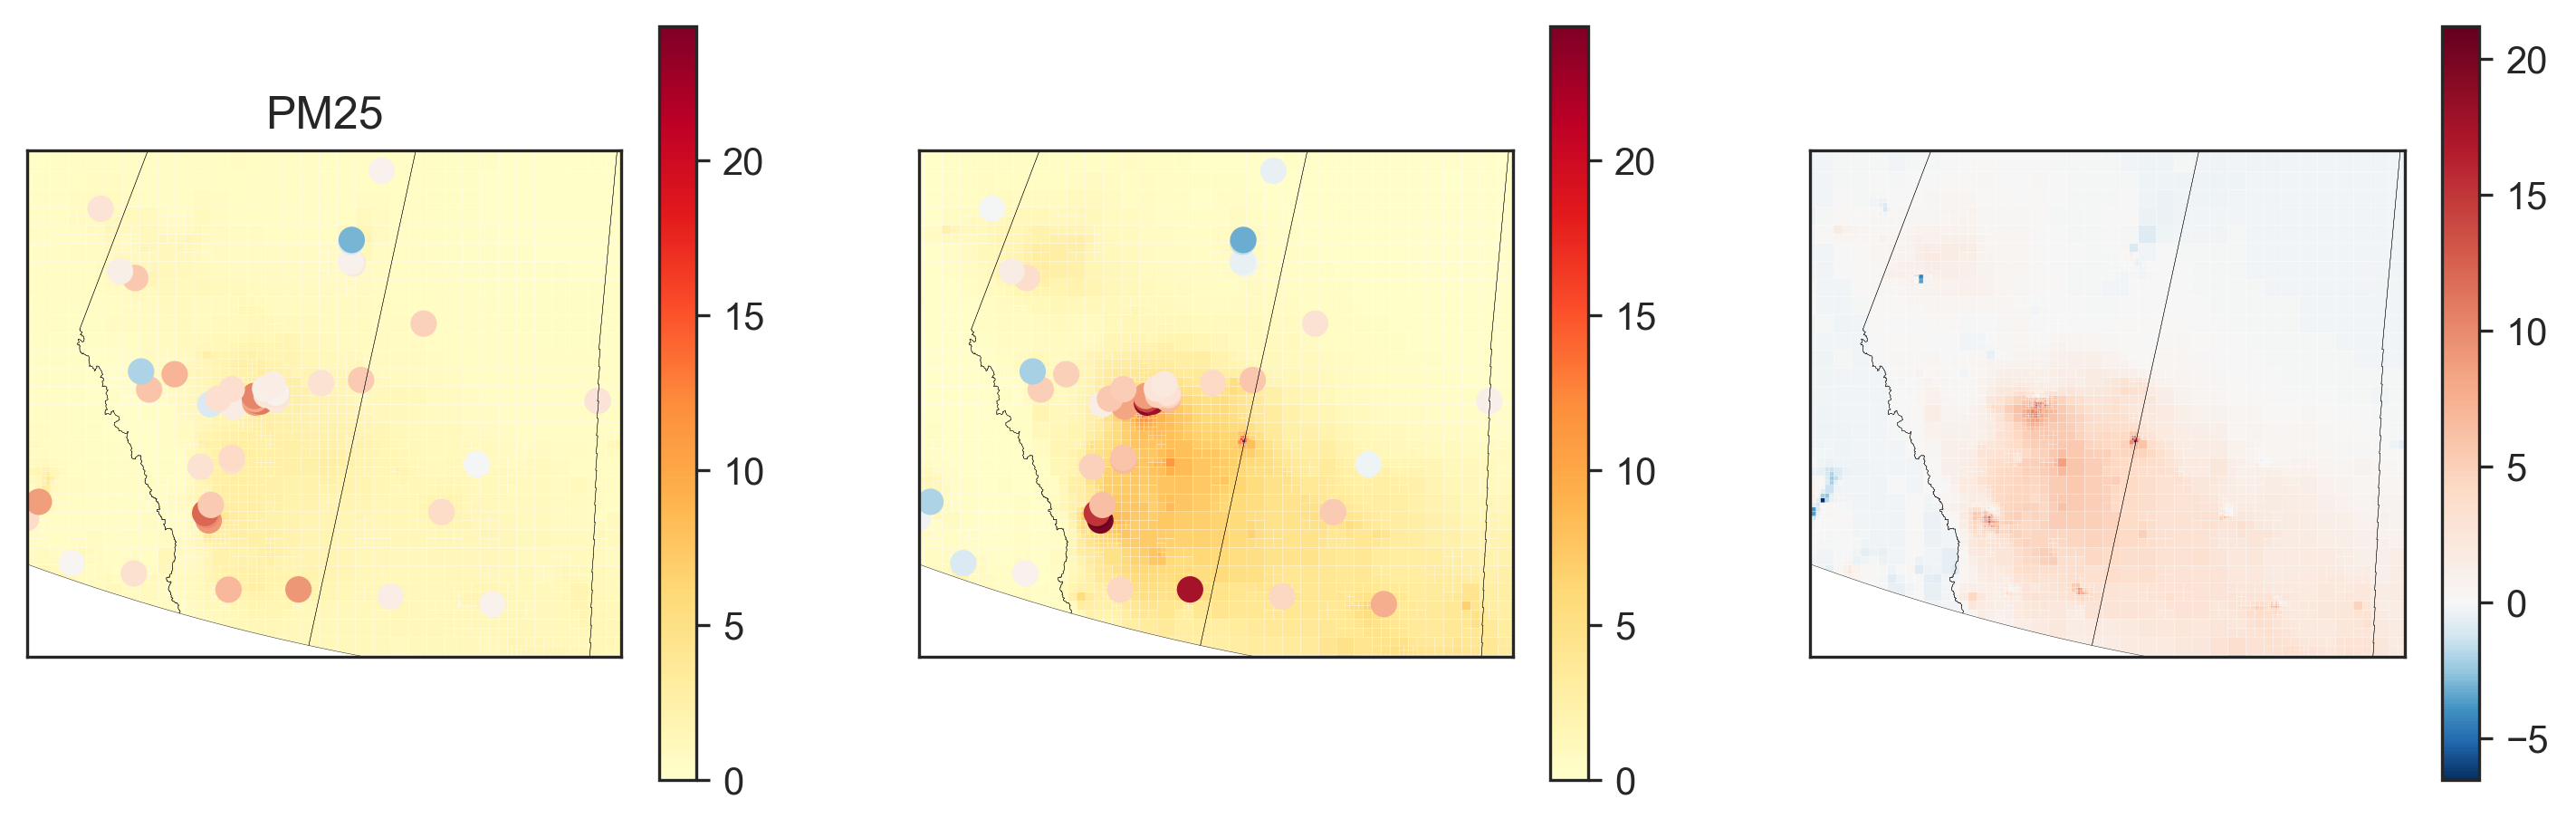

In [283]:
#Plot model-obs differences
#fig,axs = plt.subplots(1,3,figsize = (12,12),dpi=300,sharex=True,sharey=True)
legend=True
lgdshk = 0.3
lnwdth = 0.05
alpha = 1.0
cmap='YlOrRd'
#pdb.set_trace()
for ind,vals in enumerate([['BasePM25','TotalPM25']]):
    fig,axs = plt.subplots(1,3,figsize = (12,12),dpi=300,sharex=True,sharey=True)
    for ax in axs:
        provinces.geometry.boundary.plot(ax=ax, color=None, edgecolor='black',linewidth=0.1)
    delname = 'delta_'+vals[0][4:]
    #Set the row - 6 sets of three
    try:
        axs.shape[1]
        ax = axs[ind]
    except IndexError:
        ax = axs
    #Use the ranges to set the vlims
    vlim1 = [0,max(max(inmap_outs.loc[:,vals[0]]),max(inmap_outs.loc[:,vals[1]]))]
    vlim2 = [min(min(inmap_outs.loc[:,delname]),min(inmap_outs.loc[:,delname])),
             max(max(inmap_outs.loc[:,delname]),max(inmap_outs.loc[:,delname]))]
    vlim = [(vlim1),(vlim2)]
    #Define shifted colormap
    cmap2 = ihf.shiftedColorMap(matplotlib.cm.RdBu_r, start=0, midpoint=1-vlim[1][1]/(vlim[1][1]+np.abs(vlim[1][0])), stop=1.0, name='shiftedcmap')
    #Plot as reference value, predicted value, and difference. We will have this at the bottom
    inmap_outs.plot(vals[0],legend=legend,ax=ax[0],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=cmap,vmin=vlim[0][0],vmax=vlim[0][1])
    inmap_outs.plot(vals[1],legend=legend,ax=ax[1],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=cmap,vmin=vlim[0][0],vmax=vlim[0][1])
    inmap_outs.plot(delname,legend=legend,ax=ax[2],legend_kwds={'shrink':lgdshk},linewidth=lnwdth,alpha=alpha,cmap=cmap2,vmin=vlim[1][0],vmax=vlim[1][1])
    #Then, on top of this and using the same color scale, plot scatterplot
    obsgdf.loc[:,'del_gem'] = obsgdf.loc[:,'BasePM25'] - obsgdf.loc[:,'BasePMobs']
    obsgdf.loc[:,'del_inmap'] = obsgdf.loc[:,'TotalPM25'] - obsgdf.loc[:,'BasePMobs']
    obsgdf.plot('del_gem',legend=False,ax=ax[0],cmap=cmap2)
    obsgdf.plot('del_inmap',legend=False,ax=ax[1],cmap=cmap2)
    ax[0].set_title(vals[0][4:])
    axs[0].set_xticks([]);
    axs[0].set_yticks([]);
    #Set limits to Canada
    axs[0].set_xlim(-2579201.070414297, 3165870.);
    axs[0].set_ylim(76856.48815160134, 4270028.);
    #Set to AB
    #axs[0].set_xlim(-1649863, -320431.);
    #axs[0].set_ylim(1104737, 2236402.);
    #inmap_outs
    #state_outline = gpd.read_file('/Users/rivkahgf/Downloads/evaldata_v1.6.1/states.shp')
    figpath = 'D:/Sync/LEAP/Projects/INMAP-GEMMACH/Documents/Figs/'
    #fig.savefig(figpath+'BaseCase_EvalPlot.pdf',format='pdf')
    #fig.savefig(figpath+'Obs_EvalPlot_PM25.tif',format='tif')

In [282]:
fig.savefig(figpath+'Obs_EvalPlot_PM25AB.tif',format='tif')

In [245]:
#obsgdf[obsgdf.PRENAME== nan]
for nm in obsgdf.PRENAME.unique():
    print(nm)
    print(len(obsgdf[obsgdf.PRENAME==nm]))
    
  

Ontario
42
Nova Scotia
7
New Brunswick
8
Quebec
46
Prince Edward Island
3
Newfoundland and Labrador
6
British Columbia
46
Saskatchewan
7
Alberta
37
Manitoba
4
Northwest Territories
3
Yukon
1
Nunavut
1


In [55]:
inmap_outs.loc[:, ['BaseNOx', 'NOx','BaseSOx','SOx', 'BaseVOC']].mean()

BaseNOx    0.000821
NOx        3.192053
BaseSOx    0.000175
SOx        0.074679
BaseVOC    0.000845
dtype: float64

In [ ]:
inmap_outs.loc[:,['BasePM25','TotalPM25','BasePNO3','PNO3','BasePNH4','PNH4','BasePSO4','PSO4','BaseSOA','SOA','PrimPM25']].mean()

C:\Users\trodge01\Anaconda3\envs\rioxarray_env\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\trodge01\Anaconda3\envs\rioxarray_env\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\trodge01\Anaconda3\envs\rioxarray_env\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\trodge01\Anaconda3\envs\rioxarray_env\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path

<xarray.DataArray 'Dz' (band: 85, y: 4, x: 4)>
array([[[  19.958914,   18.550432,   18.13977 ,   18.84307 ],
        [  20.880558,   18.920607,   18.061615,   19.009007],
        [  21.28722 ,   18.255959,   19.171917,   20.861061],
        [  21.549278,   19.96966 ,   21.033842,   22.028435]],

       [[  39.85961 ,   37.18439 ,   36.392696,   37.686874],
        [  41.739044,   37.903908,   36.167904,   37.985435],
        [  42.464127,   36.58839 ,   38.33553 ,   41.665474],
        [  43.0158  ,   39.995033,   42.069534,   43.97075 ]],

       ...,

       [[3155.4348  , 3117.483   , 3127.8203  , 3351.3357  ],
        [3320.108   , 3350.6792  , 3317.1885  , 3476.5872  ],
        [3260.019   , 3326.718   , 3338.729   , 3314.7302  ],
        [3280.9336  , 3278.6943  , 3276.7861  , 3275.2637  ]],

       [[        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 77 78 79 80 81 82 83 84 85
  * y            (y) float64 0.5 1.5 2.5 3.5
  * x            (x) float64 0.5 1.5 2.5 3.5
    spatial_ref  int32 ...
Attributes:
    description:   Vertical grid size
    NETCDF_DIM_z:  1
    units:         ('m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm...

In [122]:
#fpath = 'D:/GlobusConnect/InMap/test/' #Tim PC
fpath = 'D:/Globus Connect Personal/Data/InMAP/Emissions/' #El Nino
area = fpath+'BASEGM_2015_E010_major_lcc.shp'
outshp = gpd.read_file(area)
#outshp.head()

In [110]:
#(outmajor.EPC1+outmajor.ECM1+outmajor.ESU1).sum()
#outmajor.update({'PM25':(outmajor.EPC1+outmajor.ECM1+outmajor.ESU1)})
#outmajor.PM25.mean()
#outarea.PM25
#outarea = outarea.fillna(0)
# rs.zonal_stats(vectors=provinces['geometry'],raster=outarea[V].values[0],
#                affine=affine,stats='sum',nodata=0.0,all_touched=False)
#utarea = xr.open_dataset(area,engine='rasterio',decode_times=False)
emiss = gpd.read_file('D:/Globus Connect Personal/Data/InMAP/Emissions/BAU_2020_E108_majorpts.shp')

In [120]:
#Output the average height, diameter, temperature,velocity and geometry for each grid cell
#Load and transform
# emiss = gpd.read_file('D:/Globus Connect Personal/Data/InMAP/Emissions/BAU_2020_E108_majorpts.shp')
# fpath = 'D:/Globus Connect Personal/Data/InMAP/Emissions/' #El Nino
#area = fpath+'BASEGM_2015_E010_major_lcc.shp'
#
emitter_stats = emiss.loc[:,['height','diameter','temperatur','velocity','geometry']]
emitter_stats = emitter_stats.set_crs('EPSG:4326')
emitter_stats = emitter_stats.to_crs('ESRI:102002')


In [123]:
#Following this guide https://gis.stackexchange.com/questions/358735/how-to-obtain-mean-maximum-and-mininum-of-all-points-located-within-polygons-u
#First get all the polygons for the points 
from geopandas.tools import sjoin
#points_polys = gpd.sjoin(emitter_stats, outshp, how="left")
stats_pt = points_polys.groupby('id_right')['value1','value2'].agg(['mean'])


height_left  diameter  temperatur  velocity  \
0         16.9      0.88       466.3  5.041932   
1         16.9      0.88       466.3  5.041932   
2         16.9      0.88       466.3  5.041932   
3         16.9      0.88       466.3  5.041932   
4         16.9      0.88       466.3  5.041932   

                         geometry  index_right       NH3        NOx      PM25  \
0  POINT (1370840.286 501850.077)     284344.0  0.000000   0.257269  0.000750   
1  POINT (1326692.305 482944.654)     285812.0  0.445122  38.346756  9.972227   
2  POINT (1326692.305 482944.654)     285812.0  0.445122  38.346756  9.972227   
3  POINT (1370840.286 501850.077)     284344.0  0.000000   0.257269  0.000750   
4  POINT (1263254.071 515777.959)     283598.0  0.000000   0.396352  0.000383   

         SOx       VOC  Velocity   temp  Diam  height_right  
0    0.00000  0.013248       9.0  350.0   3.0         150.0  
1  183.37294  2.626447       9.0  350.0   3.0         150.0  
2  183.37294  2.626447       9.0  350.0   3.0         150.0  
3    0.00000  0.013248       9.0  350.0   3.0         150.0  
4    0.00000  0.020164       9.0  350.0   3.0         150.0

In [3]:
#Sum Emissions - by province and total
import geopandas as gpd
import rasterstats as rs
fpath = 'D:/GlobusConnect/InMap/test/' #Tim PC
#fpath = 'D:\Globus Connect Personal\Data\InMAP\Emissions/' #El Nino
scenario = 'BASEGM_2015_E010'
#Had to put in same coordinate system
provinces = gpd.read_file('D:\Sync\LEAP\Projects\INMAP-GEMMACH\Data\Rivkah_data\scripts\provinces_lcc.shp')
#area = fpath+scenario+'_area_lcc2.nc'
#major = fpath+scenario+'_major_lcc2.nc'
area = fpath+scenario+'_area_lcc.nc'
major = fpath+scenario+'_major_lcc.nc'
#Load the netcdf files
outarea = xr.open_dataset(area,engine='rasterio',decode_times=False)
outmajor = xr.open_dataset(major,engine='rasterio',decode_times=False)
#outmajor.update({'PM25':(outmajor.EPC1+outmajor.ECM1+outmajor.ESU1)})
#Determine the affine
affine=outarea.rio.transform()
#Make the output files
areashp=provinces.copy(deep=True)
#areashp.loc[:,'NH3':'VOC']=0.0
majorshp = areashp.copy(deep=True)
for V in ['NH3','NOx','PM25','SOx','VOC']:
    areashp.loc[:,V] =np.array(pd.DataFrame(rs.zonal_stats(vectors=provinces['geometry'],
                           raster=outarea[V].values[0],affine=affine,stats='sum',nodata=0.0,all_touched=False)))
    majorshp.loc[:,V] =np.array(pd.DataFrame(rs.zonal_stats(vectors=provinces['geometry'],
                            raster=outmajor[V].values[0],affine=affine,stats='sum',nodata=0.0,all_touched=False)))
    areashp.loc[:,V] = areashp.loc[:,V].fillna(0)
    majorshp.loc[:,V] = majorshp.loc[:,V].fillna(0)

In [4]:
#Calculate the sum - convert from g/s to kilotonnes/yr
#Baseline values from https://www.canada.ca/en/environment-climate-change/services/environmental-indicators/air-pollutant-emissions.html
#2015 kt/yr SOx 1 064.5; NOx = 1 546.0; VOC 1 710.7; NH3 467.9; PM25 1 514.6 (583.4 no dust & fires)
#2017 kt/yr SOx 948.1; NOx = 1 495.3; VOC 1 601.3; NH3 457.7;PM25 1 511.9 (574.8 no dust & fires)
(areashp.loc[:,'NH3':].sum()+majorshp.loc[:,'NH3':].sum())*3.154e-2

NH3      426.253585
NOx      914.497017
PM25     518.163344
SOx      864.882193
VOC     1083.036190
dtype: float64

In [5]:
areashp.loc[:,'NH3':].mean(),majorshp.loc[:,'NH3':].mean()

(NH3     1024.294201
 NOx     1309.975518
 PM25    1211.911024
 SOx      141.469705
 VOC     2395.757939
 dtype: float64,
 NH3       15.297977
 NOx      920.396213
 PM25      51.840363
 SOx     1967.896163
 VOC      245.664894
 dtype: float64)

In [48]:
#Test preproc outputs
path = 'D:/InMAP_Canada/cmd/inmap/testdata/preproc/'
#testds = xr.open_dataset(path+ 'inmapData_GEMMACH_test.nc',engine='rasterio')
augds = xr.open_dataset('D:/GlobusConnect/InMap/test/preproc_outs/Monthly/inmapData_GEMMACH_August.nc', decode_coords="all")

In [5]:
#Full domain preproc outputs
fpath = 'D:/GlobusConnect/InMap/test/Inmap_outs/' #Tim PC
#fpath = 'D:\Globus Connect Personal\Data\InMAP\Preproc/'#el_nino
ds1 = xr.open_dataset(fpath+'inmapData_GEMMACH_BASEGM_2015_017_fillnearest.nc',engine='rasterio')
ds2 = xr.open_dataset(fpath+'inmapData_GEMMACH_BASEGM_2015_017_fillnearest_corrected.nc',engine='rasterio')
ds1

C:\Users\trodge01\Anaconda3\envs\rioxarray_env\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\trodge01\Anaconda3\envs\rioxarray_env\lib\site-packages\rioxarray\_io.py:839: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
C:\Users\trodge01\Anaconda3\envs\rioxarray_env\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\trodge01\Anaconda3\envs\rioxarray_env\lib\site-packages\rioxarray\_io.py:839: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning

<xarray.Dataset>
Dimensions:                     (band: 85, y: 669, x: 744)
Coordinates:
  * band                        (band) int64 1 2 3 4 5 6 7 ... 80 81 82 83 84 85
  * y                           (y) float64 0.5 1.5 2.5 ... 666.5 667.5 668.5
  * x                           (x) float64 0.5 1.5 2.5 ... 741.5 742.5 743.5
    spatial_ref                 int32 ...
Data variables: (12/45)
    Pblh                        (band, y, x) float32 ...
    NHPartitioning              (band, y, x) float32 ...
    NOPartitioning              (band, y, x) float32 ...
    NOxDryDep                   (band, y, x) float32 ...
    OtherGasWetDep              (band, y, x) float32 ...
    ParticleDryDep              (band, y, x) float32 ...
    ...                          ...
    pS                          (band, y, x) float32 ...
    Kxxyy                       (band, y, x) float32 ...
    Kzz                         (band, y, x) float32 ...
    M2d                         (band, y, x) float32 ...
    M2u                         (band, y, x) float32 ...
    NH3DryDep                   (band, y, x) float32 ...
Attributes:
    comment:       InMAP meteorology and baseline chemistry data file
    data_version:  1.2.0
    dx:            10002.6608465054
    dy:            10002.6608465054
    nx:            744
    ny:            669
    x0:            -4184312.05377675
    y0:            -2029822.82977676

C:\Users\trodge01\Anaconda3\envs\rioxarray_env\lib\site-packages\rioxarray\_io.py:839: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
C:\Users\trodge01\Anaconda3\envs\rioxarray_env\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\trodge01\Anaconda3\envs\rioxarray_env\lib\site-packages\rioxarray\_io.py:839: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
C:\Users\trodge01\Anaconda3\envs\rioxarray_env\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driv

<xarray.Dataset>
Dimensions:                     (band: 85, y: 669, x: 744)
Coordinates:
  * band                        (band) int64 1 2 3 4 5 6 7 ... 80 81 82 83 84 85
  * y                           (y) float64 0.5 1.5 2.5 ... 666.5 667.5 668.5
  * x                           (x) float64 0.5 1.5 2.5 ... 741.5 742.5 743.5
    spatial_ref                 int32 ...
Data variables: (12/45)
    Pblh                        (band, y, x) float32 ...
    NHPartitioning              (band, y, x) float32 ...
    NOPartitioning              (band, y, x) float32 ...
    NOxDryDep                   (band, y, x) float32 ...
    OtherGasWetDep              (band, y, x) float32 ...
    ParticleDryDep              (band, y, x) float32 ...
    ...                          ...
    pS                          (band, y, x) float32 ...
    Kxxyy                       (band, y, x) float32 ...
    Kzz                         (band, y, x) float32 ...
    M2d                         (band, y, x) float32 ...
    M2u                         (band, y, x) float32 ...
    NH3DryDep                   (band, y, x) float32 ...
Attributes:
    comment:       InMAP meteorology and baseline chemistry data file
    data_version:  1.2.0
    dx:            10002.6608465054
    dy:            10002.6608465054
    nx:            744
    ny:            669
    x0:            -4184312.05377675
    y0:            -2029822.82977676

In [88]:
vals = ['TotalPM25','aSOA','aVOC','bSOA','bVOC','gNH','gNO','gS','pNH','pNO','pS']
preprocavs = pd.DataFrame(columns=['PM25','pNO','pNH','pS'])
preprocavs.loc['ds1',:] = np.array([ds1.TotalPM25.mean(),ds1.pNO.mean(),ds1.pNH.mean(),ds1.pS.mean()])
preprocavs.loc['ds2',:] = np.array([ds2.TotalPM25.mean(),ds2.pNO.mean(),ds2.pNH.mean(),ds2.pS.mean()])
preprocavs
#ds1.pS.mean(),ds2.pS.mean()

PM25       pNO       pNH        pS
ds1  0.283999  2.092427  0.099278  0.122333
ds2  0.283999  0.472672  0.000117  0.040834

BasePM25     2.540947
TotalPM25    4.183311
BasePNO3     0.000140
PNO3         1.117145
BasePNH4     0.000089
PNH4         0.761102
BasePSO4     0.000064
PSO4         0.679679
BaseSOA      0.000034
SOA          0.131944
PrimPM25     1.493440

In [136]:
ds1.sel(band=80).alt.mean()

<xarray.DataArray 'alt' ()>
array(863.86176, dtype=float32)
Coordinates:
    band         int64 80
    spatial_ref  int32 0

In [90]:
#Test some preproc stuff.xr.open_dataset(fpath+'inmapData_GEMMACH_BASEGM_2015_017_fillnearest.nc',engine='rasterio')
testpath = 'D:/InMAP_Canada/cmd/inmap/testdata/preproc/gemmach/'
gemgeo = xr.open_dataset(testpath+'gem_geophy_test.nc',engine='rasterio')
gemgeo

<xarray.Dataset>
Dimensions:                  (y: 4, x: 4, band: 1)
Coordinates:
  * y                        (y) float64 3.812e+06 2.141e+06 4.708e+05 -1.2e+06
  * x                        (x) float64 -3.259e+06 -1.399e+06 ... 2.322e+06
  * band                     (band) int32 1
    lambert_conformal_conic  int32 ...
Data variables: (12/26)
    VF01                     (band, y, x) float32 ...
    VF10                     (band, y, x) float32 ...
    VF11                     (band, y, x) float32 ...
    VF12                     (band, y, x) float32 ...
    VF13                     (band, y, x) float32 ...
    VF14                     (band, y, x) float32 ...
    ...                       ...
    VF04                     (band, y, x) float32 ...
    VF05                     (band, y, x) float32 ...
    VF06                     (band, y, x) float32 ...
    VF07                     (band, y, x) float32 ...
    VF08                     (band, y, x) float32 ...
    VF09                     (band, y, x) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    comment:      GEOPHY_VF
    Conventions:  CF-1.6
    delta_x:      1860494.917446638
    delta_y:      1672945.026575001
    history:      Tue May 23 16:31:53 2023: ncks -6 -O /home/tfmrodge/scratch...
    institution:  Environment and Climate Change Canada / Environnement et Ch...
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...
    source:       Global Environmental Multiscale - Modelling Air-quality and...
    title:        Selected GEM-MACH inputs and outputs

In [20]:
# read in station data
BAM_hourly = pd.read_excel('/Users/rivkahgf/Documents/GitHub/inmap/PM2.5_BAM.xlsx')
TEOM_hourly = pd.read_excel('/Users/rivkahgf/Documents/GitHub/inmap/PM2.5_TEOM.xlsx')
#print(BAM_hourly.shape)
#print(TEOM_hourly.shape)
# NAPS uses -999 for missing data, change to NaN
BAM_hourly[BAM_hourly==-999]=np.nan
TEOM_hourly[TEOM_hourly==-999]=np.nan

In [24]:
# group measurements by station to see which stations are missing measurements

BAM_hourly.groupby('Station')['Station'].count()

Station
30901     365
31001     365
40203     365
40207     365
40801     365
50129     365
50311     365
50604     365
51501     365
52001     365
52201     365
52301     365
52401     365
52701     365
52801     245
53201     365
53301     365
53601     365
53701     365
53801     365
54801     365
54901     365
55001     335
55101     122
55201     365
55301     365
129003    365
Name: Station, dtype: int64

In [26]:
print(TEOM_hourly.groupby('Station')['Station'].count())

Station
10102     365
10301     365
10401     365
30120     730
30310     730
         ... 
105001    365
105101    362
105604    365
106502    365
119003    365
Name: Station, Length: 153, dtype: int64


In [27]:
# read in station information with locations

BAM_stations = pd.read_excel('/Users/rivkahgf/Documents/GitHub/inmap/NAPS_station_BAM.xlsx')
TEOM_stations = pd.read_excel('/Users/rivkahgf/Documents/GitHub/inmap/NAPS_station_TEOM.xlsx')

In [28]:
# set station IDs

BAM_stat_id = BAM_stations['NAPS ID']
TEOM_stat_id = TEOM_stations['NAPS ID']

In [90]:
# separate out only the hourly measurements
# average the hourly measurements to daily measurements
# change station ID type to integer

BAM_only_meas = BAM_hourly.iloc[:,8:32]
BAM_daily_avg = BAM_only_meas.mean(axis=1)
BAM_daily_df = pd.DataFrame(BAM_daily_avg, columns=['Daily Average'])
BAM_meas_stat_id = BAM_hourly.iloc[:,1].astype(int)

TEOM_only_meas = TEOM_hourly.iloc[:,8:32]
TEOM_daily_avg = TEOM_only_meas.mean(axis=1)
TEOM_daily_df = pd.DataFrame(TEOM_daily_avg, columns=['Daily Average'])
TEOM_meas_stat_id = TEOM_hourly.iloc[:,1].astype(int)

In [91]:
# create one dataframe from the station IDs and the daily averages

BAM_daily_avg = pd.concat([BAM_meas_stat_id, BAM_daily_df], axis=1)
TEOM_daily_avg = pd.concat([TEOM_meas_stat_id, TEOM_daily_df], axis=1)
TEOM_daily_avg.head()

Station  Daily Average
0    50129       8.041667
1    50129       7.416667
2    50129      16.583333
3    50129       8.000000
4    50129       5.954545

In [92]:
# use groupby to change daily averages to annual averages

BAM_annual_avg = BAM_daily_avg.groupby('Station', as_index=False)[['Daily Average']].mean()
TEOM_annual_avg = TEOM_daily_avg.groupby('Station', as_index=False)[['Daily Average']].mean()

In [93]:
# rename the average measurement column

BAM_annual_avg.rename(columns={'Daily Average':'Annual Average'}, inplace=True)
TEOM_annual_avg.rename(columns={'Daily Average':'Annual Average'}, inplace=True)

In [98]:
# extract the station locations from the station dataframe and join to the annual averages

BAM_stat_loc = BAM_stations.iloc[:,3:5]
BAM_loc_avg = pd.concat([BAM_annual_avg, BAM_stat_loc], axis=1)
TEOM_stat_loc = TEOM_stations.iloc[:,3:5]
TEOM_loc_avg = pd.concat([TEOM_annual_avg, TEOM_stat_loc], axis=1)

In [110]:
# import the US InMAP simulation
# import the outline of US states
# create geodataframe from the pandas dataframe with the stations using the latitude and longitude

US_simulation = gpd.read_file('/Users/rivkahgf/Downloads/2005nei_output_us1.shp')
state_outline = gpd.read_file('/Users/rivkahgf/Downloads/evaldata_v1.6.1/states.shp')
BAM_gdf = gpd.GeoDataFrame(BAM_loc_avg,geometry=gpd.points_from_xy(BAM_loc_avg.Longitude, BAM_loc_avg.Latitude))
TEOM_gdf = gpd.GeoDataFrame(TEOM_loc_avg,geometry=gpd.points_from_xy(TEOM_loc_avg.Longitude, TEOM_loc_avg.Latitude))

In [117]:
# change the simulation and state projections to the same one
# set the projection of the stations

sim_map_proj = US_simulation.to_crs({'init': 'epsg:4326'})
state_map_proj = state_outline.to_crs({'init': 'epsg:4326'})
BAM_gdf.crs = {'init': 'epsg:4326'}
TEOM_gdf.crs = {'init': 'epsg:4326'}

In [121]:
# join the stations and the US simulation grid
# option "inner" means it keeps the data of both the station locations and the grid cell information
# option "intersects" means a cell from the grid is joined to a station if they intersect in any way

BAM_stat_in_grid = gpd.sjoin(BAM_gdf, sim_map_proj, how="inner", op='intersects')
TEOM_stat_in_grid = gpd.sjoin(TEOM_gdf, sim_map_proj, how="inner", op='intersects')

In [122]:
TEOM_stat_in_grid.head()

Station  Annual Average  Latitude  Longitude                    geometry  \
0  10102.0        4.530960   45.6517   -73.5738  POINT (-73.57380 45.65170)   
3  30120.0        4.368064   45.6413   -73.4994  POINT (-73.49940 45.64130)   
4  30310.0        5.685435   45.4978   -73.5731  POINT (-73.57310 45.49780)   
5  40103.0        4.322877   45.5027   -73.6639  POINT (-73.66390 45.50270)   
6  40203.0        4.266242   45.5945   -73.6415  POINT (-73.64150 45.59450)   

   index_right  AsianD   BasePM25  BlackD  LatinoD  ...      PNO3      PSO4  \
0        22363     0.0  14.865413     0.0      0.0  ...  0.230586  0.596888   
3        22363     0.0  14.865413     0.0      0.0  ...  0.230586  0.596888   
4        22363     0.0  14.865413     0.0      0.0  ...  0.230586  0.596888   
5        22363     0.0  14.865413     0.0      0.0  ...  0.230586  0.596888   
6        22363     0.0  14.865413     0.0      0.0  ...  0.230586  0.596888   

   PrimPM25       SOA       SOx  TotalPM25  TotalPop  TotalPopD  WhitNoLatD  \
0  0.328612  0.203276  3.666806   1.394511       0.0        0.0         0.0   
3  0.328612  0.203276  3.666806   1.394511       0.0        0.0         0.0   
4  0.328612  0.203276  3.666806   1.394511       0.0        0.0         0.0   
5  0.328612  0.203276  3.666806   1.394511       0.0        0.0         0.0   
6  0.328612  0.203276  3.666806   1.394511       0.0        0.0         0.0   

   WindSpeed  
0   5.193621  
3   5.193621  
4   5.193621  
5   5.193621  
6   5.193621  

[5 rows x 24 columns]

In [131]:
# import file with the outlines of Canadian provinces and set the projection to the same as the others

Canada_outline = gpd.read_file('/Users/rivkahgf/Documents/GitHub/inmap/gpr_000b11a_e.shp')
print(Canada_outline.crs)
Canada_map_proj = Canada_outline.to_crs({'init': 'epsg:4326'})

{'init': 'epsg:4269'}


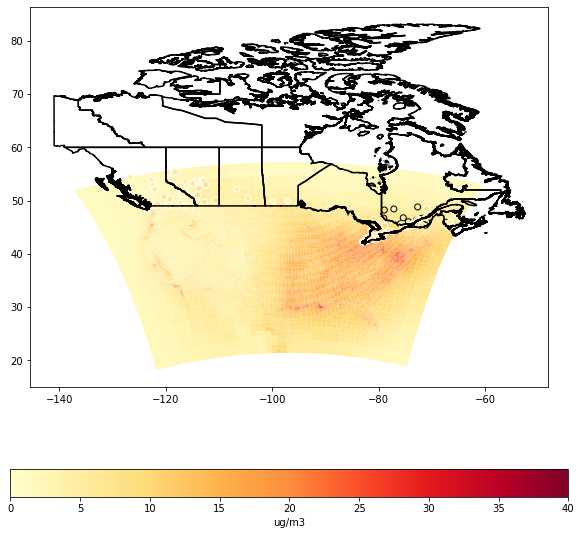

In [130]:
# Map the WRF-Chem simulation
# choose YlOrRd as the base colormap, set the max concentration to 40 and minimum to 0

base = sim_map_proj.plot(column = 'BasePM25', cmap='YlOrRd', vmax = 40, vmin = 0, figsize=(10,10), legend=True, legend_kwds={'label': "ug/m3",'orientation': "horizontal"})
Canada_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black')
plt.scatter(BAM_stat_in_grid['Longitude'], BAM_stat_in_grid['Latitude'], marker='o', c=BAM_stat_in_grid['Annual Average'], cmap = 'YlOrRd', vmax = 40, vmin = 0, edgecolors='black')
plt.scatter(TEOM_stat_in_grid['Longitude'], TEOM_stat_in_grid['Latitude'], marker='o', c=TEOM_stat_in_grid['Annual Average'], cmap = 'YlOrRd', vmax = 40, vmin = 0, edgecolors='white')

In [135]:
# join the US simulation with the Canadian map to cut out unnecessary US information

Can_simulation = gpd.sjoin(sim_map_proj, Canada_map_proj, how="inner", op='intersects')
Can_simulation.head()

AsianD  BasePM25  BlackD  LatinoD       NH3       NOx  NativeD      PNH4  \
98      0.0  1.690619     0.0      0.0  0.000011  0.291973      0.0  0.000880   
99      0.0  1.430238     0.0      0.0  0.000005  0.159850      0.0  0.000422   
944     0.0  2.435401     0.0      0.0  0.000396  0.675117      0.0  0.006083   
945     0.0  1.824244     0.0      0.0  0.000221  0.338076      0.0  0.004192   
946     0.0  1.748287     0.0      0.0  0.000173  0.442768      0.0  0.003680   

         PNO3      PSO4  ...  WhitNoLatD  WindSpeed  \
98   0.003929  0.044548  ...         0.0   8.285168   
99   0.001788  0.023156  ...         0.0   8.101509   
944  0.012088  0.082936  ...         0.0   7.227553   
945  0.007593  0.053764  ...         0.0   6.126860   
946  0.005829  0.066497  ...         0.0   5.756727   

                                              geometry  index_right  PRUID  \
98   POLYGON ((-130.52785 48.20002, -126.87780 49.0...            0     59   
99   POLYGON ((-131.97543 50.58020, -128.19458 51.4...            0     59   
944  POLYGON ((-126.46237 48.26726, -125.23733 48.5...            0     59   
945  POLYGON ((-126.87780 49.07744, -125.63787 49.3...            0     59   
946  POLYGON ((-127.30467 49.88416, -126.04955 50.1...            0     59   

                                      PRNAME           PRENAME  \
98   British Columbia / Colombie-Britannique  British Columbia   
99   British Columbia / Colombie-Britannique  British Columbia   
944  British Columbia / Colombie-Britannique  British Columbia   
945  British Columbia / Colombie-Britannique  British Columbia   
946  British Columbia / Colombie-Britannique  British Columbia   

                  PRFNAME PREABBR  PRFABBR  
98   Colombie-Britannique    B.C.    C.-B.  
99   Colombie-Britannique    B.C.    C.-B.  
944  Colombie-Britannique    B.C.    C.-B.  
945  Colombie-Britannique    B.C.    C.-B.  
946  Colombie-Britannique    B.C.    C.-B.  

[5 rows x 26 columns]

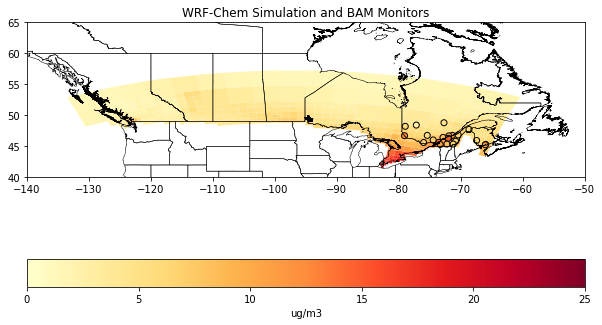

In [185]:
# plot the WRF-Chem simulation with the BAM monitors

base = Can_simulation.plot(column = 'BasePM25', cmap='YlOrRd', vmax = 25, vmin = 0, figsize=(10,10), legend=True, legend_kwds={'label': "ug/m3",'orientation': "horizontal"})
Canada_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
state_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
axes = plt.gca()
axes.set_xlim([-140,-50])
axes.set_ylim([40,65])
axes.set_title('WRF-Chem Simulation and BAM Monitors')
plt.scatter(BAM_stat_in_grid['Longitude'], BAM_stat_in_grid['Latitude'], marker='o', c=BAM_stat_in_grid['Annual Average'], cmap = 'YlOrRd', vmax = 25, vmin = 0, edgecolors='black')


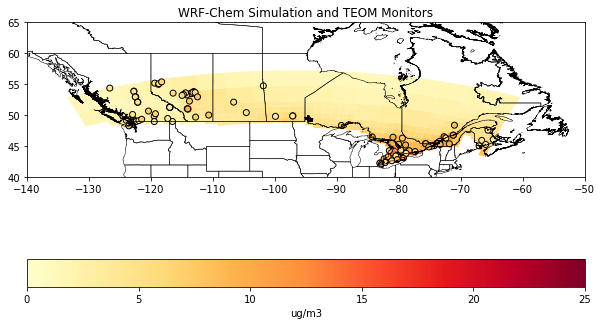

In [186]:
# plot the WRF-Chem simulation with the TEOM monitors

base = Can_simulation.plot(column = 'BasePM25', cmap='YlOrRd', vmax = 25, vmin = 0, figsize=(10,10), legend=True, legend_kwds={'label': "ug/m3",'orientation': "horizontal"})
Canada_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
state_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
axes = plt.gca()
axes.set_xlim([-140,-50])
axes.set_ylim([40,65])
axes.set_title('WRF-Chem Simulation and TEOM Monitors')
plt.scatter(TEOM_stat_in_grid['Longitude'], TEOM_stat_in_grid['Latitude'], marker='o', c=TEOM_stat_in_grid['Annual Average'], cmap = 'YlOrRd', vmax = 25, vmin = 0, edgecolors='black')

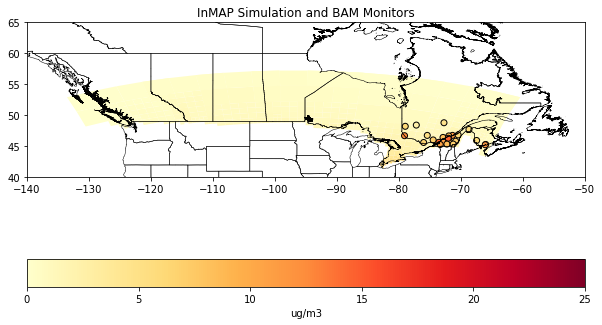

In [188]:
# plot the InMAP simulation with the BAM monitors

base = Can_simulation.plot(column = 'TotalPM25', cmap='YlOrRd', vmax = 25, vmin = 0, figsize=(10,10), legend=True, legend_kwds={'label': "ug/m3",'orientation': "horizontal"})
Canada_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
state_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
axes = plt.gca()
axes.set_xlim([-140,-50])
axes.set_ylim([40,65])
axes.set_title('InMAP Simulation and BAM Monitors')
plt.scatter(BAM_stat_in_grid['Longitude'], BAM_stat_in_grid['Latitude'], marker='o', c=BAM_stat_in_grid['Annual Average'], cmap = 'YlOrRd', vmax = 25, vmin = 0, edgecolors='black')


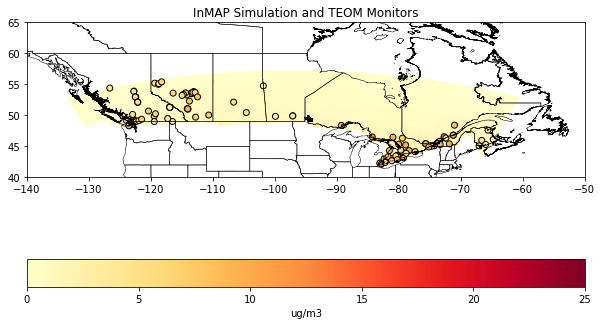

In [189]:
# plot the InMAP simulation with the TEOM monitors

base = Can_simulation.plot(column = 'TotalPM25', cmap='YlOrRd', vmax = 25, vmin = 0, figsize=(10,10), legend=True, legend_kwds={'label': "ug/m3",'orientation': "horizontal"})
Canada_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
state_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
axes = plt.gca()
axes.set_xlim([-140,-50])
axes.set_ylim([40,65])
axes.set_title('InMAP Simulation and TEOM Monitors')
plt.scatter(TEOM_stat_in_grid['Longitude'], TEOM_stat_in_grid['Latitude'], marker='o', c=TEOM_stat_in_grid['Annual Average'], cmap = 'YlOrRd', vmax = 25, vmin = 0, edgecolors='black')



Text(0.5, 0, 'NAPS total PM2.5 (ug/m3)')

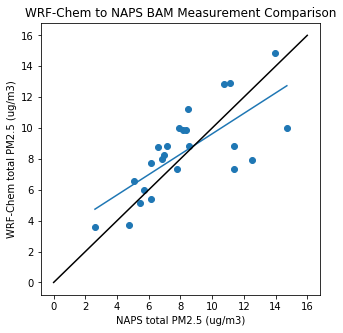

In [149]:
# preliminary plot with WRF-Chem to BAM measurements

x = BAM_stat_in_grid['Annual Average']
y2 = BAM_stat_in_grid['BasePM25']
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x, y2)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)))
ax.plot([0, 16],[0, 16], color='black')
ax.set_title('WRF-Chem to NAPS BAM Measurement Comparison')
ax.set_ylabel('WRF-Chem total PM2.5 (ug/m3)')
ax.set_xlabel('NAPS total PM2.5 (ug/m3)')

Text(0.5, 0, 'NAPS total PM2.5 (ug/m3)')

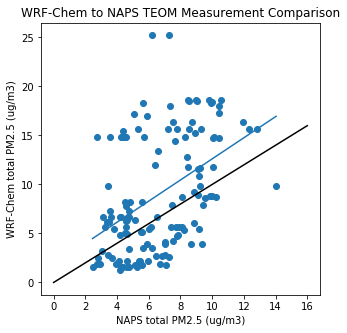

In [150]:
# preliminary plot with WRF-Chem to TEOM measurements

x = TEOM_stat_in_grid['Annual Average']
y2 = TEOM_stat_in_grid['BasePM25']
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x, y2)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)))
ax.plot([0, 16],[0, 16], color='black')
ax.set_title('WRF-Chem to NAPS TEOM Measurement Comparison')
ax.set_ylabel('WRF-Chem total PM2.5 (ug/m3)')
ax.set_xlabel('NAPS total PM2.5 (ug/m3)')

Text(0.5, 0, 'NAPS total PM2.5 (ug/m3)')

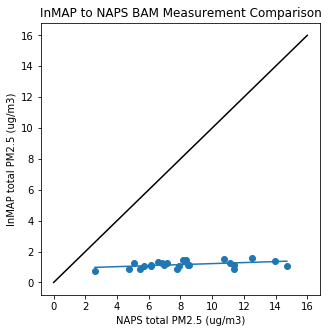

In [151]:
# preliminary plot with InMAP to BAM measurements

x = BAM_stat_in_grid['Annual Average']
y2 = BAM_stat_in_grid['TotalPM25']
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x, y2)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)))
ax.plot([0, 16],[0, 16], color='black')
ax.set_title('InMAP to NAPS BAM Measurement Comparison')
ax.set_ylabel('InMAP total PM2.5 (ug/m3)')
ax.set_xlabel('NAPS total PM2.5 (ug/m3)')

Text(0.5, 0, 'NAPS total PM2.5 (ug/m3)')

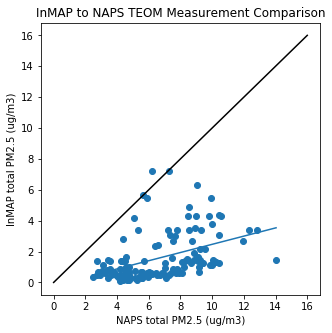

In [152]:
# preliminary plot with InMAP to TEOM measurements

x = TEOM_stat_in_grid['Annual Average']
y2 = TEOM_stat_in_grid['TotalPM25']
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x, y2)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)))
ax.plot([0, 16],[0, 16], color='black')
ax.set_title('InMAP to NAPS TEOM Measurement Comparison')
ax.set_ylabel('InMAP total PM2.5 (ug/m3)')
ax.set_xlabel('NAPS total PM2.5 (ug/m3)')

In [291]:
# calculate performance statistics for WRF-Chem to BAM comparison

BAM_meas = BAM_stat_in_grid['Annual Average']
TEOM_meas = TEOM_stat_in_grid['Annual Average']
BAM_WRF_meas = BAM_stat_in_grid['BasePM25']
TEOM_WRF_meas = TEOM_stat_in_grid['BasePM25']

WRF_MB_BAM = (np.sum(BAM_WRF_meas-BAM_meas))/24
print(WRF_MB_BAM)

WRF_ME_BAM = (np.sum(np.abs(BAM_WRF_meas-BAM_meas)))/24
print(WRF_ME_BAM)

WRF_MFB_BAM = (np.sum((2*(BAM_WRF_meas-BAM_meas))/(BAM_WRF_meas+BAM_meas)))/24
print(WRF_MFB_BAM)

WRF_MFE_BAM = (np.sum((2*np.abs(BAM_WRF_meas-BAM_meas))/(BAM_WRF_meas+BAM_meas)))/24
print(WRF_MFE_BAM)

WRF_MR_BAM = np.sum(BAM_WRF_meas/BAM_meas)/24
print(WRF_MR_BAM)


0.21523284328619144
1.7557245812171451
0.038664660304231116
0.20606348271291383
1.0658331152554668


In [292]:
# calculate performance statistics for WRF-Chem to TEOM comparison

WRF_MB_TEOM = (np.sum(TEOM_WRF_meas-TEOM_meas))/24
print(WRF_MB_TEOM)

WRF_ME_TEOM = (np.sum(np.abs(TEOM_WRF_meas-TEOM_meas)))/24
print(WRF_ME_TEOM)

WRF_MFB_TEOM = (np.sum((2*(TEOM_WRF_meas-TEOM_meas))/(TEOM_WRF_meas+TEOM_meas)))/24
print(WRF_MFB_TEOM)

WRF_MFE_TEOM = (np.sum((2*np.abs(TEOM_WRF_meas-TEOM_meas))/(TEOM_WRF_meas+TEOM_meas)))/24
print(WRF_MFE_TEOM)

WRF_MR_TEOM = np.sum(TEOM_WRF_meas/TEOM_meas)/24
print(WRF_MR_TEOM)           



13.218237099904583
24.824794311440602
0.574712787299153
3.1434061307655283
7.8993987799444385


In [289]:
# calculate performance statistics for InMAP to BAM comparison

BAM_meas = BAM_stat_in_grid['Annual Average']
TEOM_meas = TEOM_stat_in_grid['Annual Average']
BAM_inmap_meas = BAM_stat_in_grid['TotalPM25']
TEOM_inmap_meas = TEOM_stat_in_grid['TotalPM25']

inmap_MB_BAM = (np.sum(BAM_inmap_meas-BAM_meas))/24
print(inmap_MB_BAM)

inmap_ME_BAM = (np.sum(np.abs(BAM_inmap_meas-BAM_meas)))/24
print(inmap_ME_BAM)

inmap_MFB_BAM = (np.sum((2*(BAM_inmap_meas-BAM_meas))/(BAM_inmap_meas+BAM_meas)))/24
print(inmap_MFB_BAM)

inmap_MFE_BAM = (np.sum((2*np.abs(BAM_inmap_meas-BAM_meas))/(BAM_inmap_meas+BAM_meas)))/24
print(inmap_MFE_BAM)

inmap_MR_BAM = np.sum(BAM_inmap_meas/BAM_meas)/24
print(inmap_MR_BAM)


-7.101812051276308
7.101812051276308
-1.4668869618551466
1.4668869618551466
0.1557855586465847


In [290]:
# calculate performance statistics for InMAP to TEOM comparison

inmap_MB_TEOM = (np.sum(TEOM_inmap_meas-TEOM_meas))/24
print(inmap_MB_TEOM)

inmap_ME_TEOM = (np.sum(np.abs(TEOM_inmap_meas-TEOM_meas)))/24
print(inmap_ME_TEOM)

inmap_MFB_TEOM = (np.sum((2*(TEOM_inmap_meas-TEOM_meas))/(TEOM_inmap_meas+TEOM_meas)))/24
print(inmap_MFB_TEOM)

inmap_MFE_TEOM = (np.sum((2*np.abs(TEOM_inmap_meas-TEOM_meas))/(TEOM_inmap_meas+TEOM_meas)))/24
print(inmap_MFE_TEOM)

inmap_MR_TEOM = np.sum(TEOM_inmap_meas/TEOM_meas)/24
print(inmap_MR_TEOM)

-28.375048367112086
28.462280216569116
-7.417593148095025
7.430622543767202
1.3056868260473011


In [181]:
print(TEOM_stat_in_grid['Annual Average'])

0      4.530960
3      4.368064
4      5.685435
5      4.322877
6      4.266242
         ...   
145    2.709317
146    3.661889
150    4.056600
151    4.188017
152    2.821570
Name: Annual Average, Length: 135, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


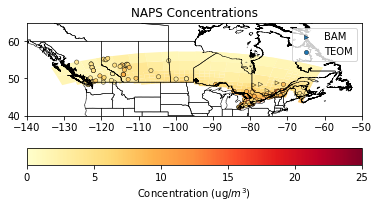

In [311]:
# map the WRF-Chem simulation with NAPS measurements

fig, base = plt.subplots(1)
Can_simulation.plot(ax=base, column = 'BasePM25', cmap='YlOrRd', vmax = 25, vmin = 0, figsize=(8,8), legend=True, legend_kwds={'label': "Concentration (ug/$m^3$)",'orientation': "horizontal"})
Canada_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
state_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
axes = plt.gca()
axes.set_xlim([-140,-50])
axes.set_ylim([40,65])
axes.set_title('NAPS Concentrations')
out = axes.scatter(BAM_stat_in_grid['Longitude'], BAM_stat_in_grid['Latitude'], marker='>', linewidths=.4, s=18, c=BAM_stat_in_grid['Annual Average'], cmap = 'YlOrRd', vmax = 25, vmin = 0, edgecolors='black', label="BAM")
out = axes.scatter(TEOM_stat_in_grid['Longitude'], TEOM_stat_in_grid['Latitude'], marker='o', linewidths=.4, s=18, c=TEOM_stat_in_grid['Annual Average'], cmap = 'YlOrRd', vmax = 25, vmin = 0, edgecolors='black', label="TEOM")
axes.legend()
fig.savefig('WRF_Chem_map_e.eps')

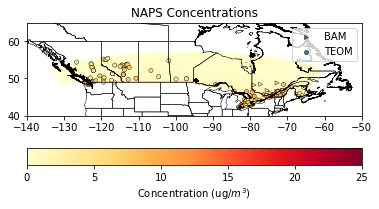

<Figure size 576x576 with 0 Axes>

In [303]:
# map the InMAP simulation with NAPS measurements

fig, base = plt.subplots(1)
Can_simulation.plot(ax=base, column = 'TotalPM25', cmap='YlOrRd', vmax = 25, vmin = 0, figsize=(8,8), legend=True, legend_kwds={'label': "Concentration (ug/$m^3$)",'orientation': "horizontal"})
Canada_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
state_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
axes = plt.gca()
axes.set_xlim([-140,-50])
axes.set_ylim([40,65])
axes.set_title('NAPS Concentrations')
out = axes.scatter(BAM_stat_in_grid['Longitude'], BAM_stat_in_grid['Latitude'], marker='>', linewidths=.4, s=18, c=BAM_stat_in_grid['Annual Average'], cmap = 'YlOrRd', vmax = 25, vmin = 0, edgecolors='black', label="BAM")
out = axes.scatter(TEOM_stat_in_grid['Longitude'], TEOM_stat_in_grid['Latitude'], marker='o', linewidths=.4, s=18, c=TEOM_stat_in_grid['Annual Average'], cmap = 'YlOrRd', vmax = 25, vmin = 0, edgecolors='black', label="TEOM")
axes.legend()
fig.savefig('inmap_map.pdf')

In [286]:
# find the difference between the simulation and measurements

WRF_BAM_diff = BAM_stat_in_grid['BasePM25']-BAM_stat_in_grid['Annual Average']
WRF_TEOM_diff = TEOM_stat_in_grid['BasePM25']-TEOM_stat_in_grid['Annual Average']

inmap_BAM_diff = BAM_stat_in_grid['TotalPM25']-BAM_stat_in_grid['Annual Average']
inmap_TEOM_diff = TEOM_stat_in_grid['TotalPM25']-TEOM_stat_in_grid['Annual Average']

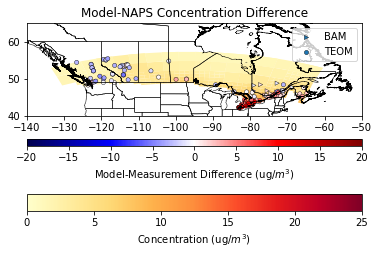

In [305]:
# map the WRF-Chem simulation with NAPS measurement difference

fig, base = plt.subplots(1)
Can_simulation.plot(ax=base, column = 'BasePM25', cmap='YlOrRd', vmax = 25, vmin = 0, figsize=(25,25), legend=True, legend_kwds={'label': "Concentration (ug/$m^3$)",'orientation': "horizontal"})
Canada_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
state_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
axes = plt.gca()
axes.set_xlim([-140,-50])
axes.set_ylim([40,65])
axes.set_title('Model-NAPS Concentration Difference')
out = axes.scatter(BAM_stat_in_grid['Longitude'], BAM_stat_in_grid['Latitude'], marker='>', linewidths=.4, s=18, c=WRF_BAM_diff, cmap = 'seismic', vmax = 20, vmin = -20, edgecolors='black', label="BAM")
out = axes.scatter(TEOM_stat_in_grid['Longitude'], TEOM_stat_in_grid['Latitude'], marker='o', linewidths=.4, s=18, c=WRF_TEOM_diff, cmap = 'seismic', vmax = 20, vmin = -20, edgecolors='black', label="TEOM")
axes.legend()
cbar = plt.colorbar(out, orientation='horizontal', aspect=50)
cbar.set_ticks(ticks=[-20,-15,-10,-5,0,5,10,15,20])
cbar.set_label('Model-Measurement Difference (ug/$m^3$)')
fig.savefig('wrf_chem_dmap.pdf')

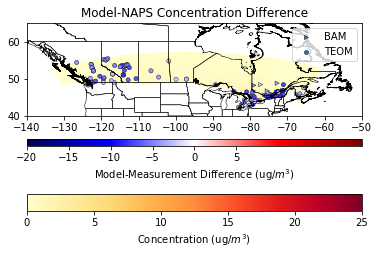

In [308]:
# map the InMAP simulation with NAPS measurement difference

fig, base = plt.subplots(1)
Can_simulation.plot(ax=base, column = 'TotalPM25', cmap='YlOrRd', vmax = 25, vmin = 0, figsize=(25,25), legend=True, legend_kwds={'label': "Concentration (ug/$m^3$)",'orientation': "horizontal"})
Canada_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
state_map_proj.geometry.boundary.plot(ax=base, color=None, edgecolor='black', linewidth=.5)
axes = plt.gca()
axes.set_xlim([-140,-50])
axes.set_ylim([40,65])
axes.set_title('Model-NAPS Concentration Difference')
out = axes.scatter(BAM_stat_in_grid['Longitude'], BAM_stat_in_grid['Latitude'], marker='>', linewidths=.4, s=18, c=inmap_BAM_diff, cmap = 'seismic', vmax = 20, vmin = -20, edgecolors='black', label="BAM")
out = axes.scatter(TEOM_stat_in_grid['Longitude'], TEOM_stat_in_grid['Latitude'], marker='o', linewidths=.4, s=18, c=inmap_TEOM_diff, cmap = 'seismic', vmax = 20, vmin = -20, edgecolors='black', label="TEOM")
axes.legend()
cbar = plt.colorbar(out, orientation='horizontal', aspect=50)
cbar.set_ticks(ticks=[-20,-15,-10,-5,0,5])
cbar.set_label('Model-Measurement Difference (ug/$m^3$)')
fig.savefig('inmap_dmap.pdf')

In [249]:
from scipy import stats

0.660245928855812
3.0233627893255983
0.5215049009576185
1.0772489948772639
1.8389288739584382
0.20399145360935975


<Figure size 360x360 with 0 Axes>

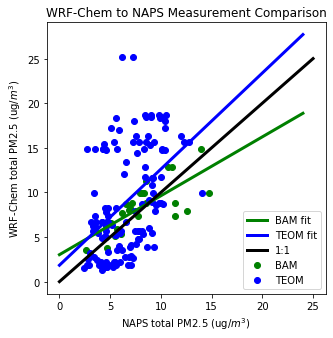

In [282]:
# plot the WRF-Chem simulation vs NAPS measurements
# get statistics on the best fit line

fig = plt.figure(figsize=(5,5))
x = np.arange(0,25)
x1 = BAM_stat_in_grid['Annual Average']
y1 = BAM_stat_in_grid['BasePM25']

WRF_BAM_slope, WRF_BAM_intercept, WRF_BAM_r, WRF_BAM_p, WRF_BAM_std_err = stats.linregress(x1,y1)
WRF_BAM_bestfit = WRF_BAM_slope*x+WRF_BAM_intercept
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x1, y1, color='green', label="BAM")
ax.plot(x,WRF_BAM_bestfit, color='green', linewidth=3, label="BAM fit")

x2 = TEOM_stat_in_grid['Annual Average']
y2 = TEOM_stat_in_grid['BasePM25']
WRF_TEOM_slope, WRF_TEOM_intercept, WRF_TEOM_r, WRF_TEOM_p, WRF_TEOM_std_err = stats.linregress(x2,y2)
WRF_TEOM_bestfit = WRF_TEOM_slope*x+WRF_TEOM_intercept
ax.scatter(x2, y2, color='blue', label="TEOM")
ax.plot(x,WRF_TEOM_bestfit, color='blue', linewidth=3, label="TEOM fit")

ax.plot([0, 25],[0, 25], color='black', linewidth=3, label="1:1")
ax.set_title('WRF-Chem to NAPS Measurement Comparison')
ax.set_ylabel('WRF-Chem total PM2.5 (ug/$m^3$)')
ax.set_xlabel('NAPS total PM2.5 (ug/$m^3$)')
ax.legend()
fig.savefig('WRF_Chem_plot.pdf')

print(WRF_BAM_slope)
print(WRF_BAM_intercept)
print(WRF_BAM_r**2)

print(WRF_TEOM_slope)
print(WRF_TEOM_intercept)
print(WRF_TEOM_r**2)

0.032897683040307546
0.8914666399628963
0.20283430275799588
0.2654446445036258
-0.18558005877055517
0.18617693243632583


<Figure size 360x360 with 0 Axes>

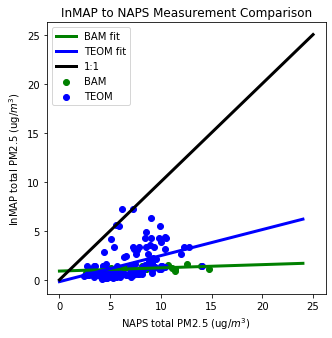

In [283]:
# plot the InMAP simulation vs NAPS measurements
# get statistics on the best fit line

x = np.arange(0,25)
x1 = BAM_stat_in_grid['Annual Average']
y1 = BAM_stat_in_grid['TotalPM25']

inmap_BAM_slope, inmap_BAM_intercept, inmap_BAM_r, inmap_BAM_p, inmap_BAM_std_err = stats.linregress(x1,y1)
inmap_BAM_bestfit = inmap_BAM_slope*x+inmap_BAM_intercept
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x1, y1, color='green', label="BAM")
ax.plot(x,inmap_BAM_bestfit, color='green', linewidth=3, label="BAM fit")

x2 = TEOM_stat_in_grid['Annual Average']
y2 = TEOM_stat_in_grid['TotalPM25']
inmap_TEOM_slope, inmap_TEOM_intercept, inmap_TEOM_r, inmap_TEOM_p, inmap_TEOM_std_err = stats.linregress(x2,y2)
inmap_TEOM_bestfit = inmap_TEOM_slope*x+inmap_TEOM_intercept
ax.scatter(x2, y2, color='blue', label="TEOM")
ax.plot(x,inmap_TEOM_bestfit, color='blue', linewidth=3, label="TEOM fit")

ax.plot([0, 25],[0, 25], color='black', linewidth=3, label="1:1")
ax.set_title('InMAP to NAPS Measurement Comparison')
ax.set_ylabel('InMAP total PM2.5 (ug/$m^3$)')
ax.set_xlabel('NAPS total PM2.5 (ug/$m^3$)')
ax.legend()
fig.savefig('inmap_plot.pdf')

print(inmap_BAM_slope)
print(inmap_BAM_intercept)
print(inmap_BAM_r**2)

print(inmap_TEOM_slope)
print(inmap_TEOM_intercept)
print(inmap_TEOM_r**2)